## Import Required Libraries

- `Numpy`: For numerical operations and array manipulations.
- `Pandas`: For loading CSV files and data manipulation.
- `Matplotlib`: For data visualization.
- `Math`: For converting angles degrees to radians and trigonometric functions.
- `Scipy`: For handling Probability Distribution Function (PDF)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import radians, cos, sin
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import mean_squared_error
import scipy.stats as sp

# Importing the provided function which calculates residual resampling.
from residual_resample import residual_resample

## Load and Clean Dataset
- Load the dataset from a CSV file.

In [2]:
# Load the Dataset 'polar0011_slower_0.csv'
observation_df_slower_0 = pd.read_csv('data/observations/polar0011_slower_0.csv')

# Rename columns.
observation_df_slower_0.columns = ['time', 'H_deg', 'V_deg', 'D_mm']

# Convert distance from mm to meters.
observation_df_slower_0['D_mm'] = observation_df_slower_0['D_mm'] / 1000.0

# Convert angles from degrees to radians.
observation_df_slower_0['H_rad'] = np.radians(observation_df_slower_0['H_deg'])
observation_df_slower_0['V_rad'] = np.radians(observation_df_slower_0['V_deg'])

# Convert time column to datetime.
observation_df_slower_0['time'] = pd.to_datetime(observation_df_slower_0['time'], format='%H:%M:%S.%f')

# Compute a time step (Δt) in seconds.
observation_df_slower_0['delta_t'] = observation_df_slower_0['time'].diff().dt.total_seconds()
ave_observation_df_slower_0 = (observation_df_slower_0['delta_t'][1:].mean())
observation_df_slower_0['delta_t'] = observation_df_slower_0['delta_t'].fillna(ave_observation_df_slower_0)

# Display Dataframe.
observation_df_slower_0.head()

,time,H_deg,V_deg,D_mm,H_rad,V_rad,delta_t
0,1900-01-01 16:29:07.378022799,46.390621,89.543313,19.881393,0.809669,1.562826,0.009993
1,1900-01-01 16:29:07.388022799,46.389260,89.547499,19.878872,0.809645,1.562899,0.010000
2,1900-01-01 16:29:07.398023199,46.391339,89.545287,19.877522,0.809682,1.562860,0.010000
3,1900-01-01 16:29:07.408023000,46.388761,89.547442,19.876017,0.809637,1.562898,0.010000
4,1900-01-01 16:29:07.418022699,46.389539,89.544286,19.877749,0.809650,1.562843,0.010000


### Measurement Noise Model:

We compute the measurement noise covariance matrix `R` using the sensor model provided in the exercise.

We use given measurement uncertainty information:
- σ_D = 0.0025 * D + 0.0025
- σ_H = σ_V = 0.0014° (Converted to Radians)

In [3]:
def R_polar(D):

    sigma_D = 0.0025 * D + 0.0025  # Standard deviation of the distance measurement.
    sigma_H = np.radians(0.0014)   # Standard deviation of the horizontal angle measurement in radians.
    sigma_V = np.radians(0.0014)   # Standard deviation of the vertical angle measurement in radians.

    # Compute the covariance matrix.
    R_polar = np.diag([sigma_D**2, sigma_H**2, sigma_V**2])
    
    return R_polar

### Measurement Model for Particle Filter (PF)

We define the measurement model of Particle Filter (PF):

- $D = \sqrt{x^2 + y^2 + z^2} $
- $H = \arctan2(y, x) $
- $V = \arccos\left(\frac{z}{D}\right) $

Measurement function h(x):
- Define a function to compute the predicted measurement from the current state.

In [4]:
def h(x):
    """
    - Nonlinear measurement function that converts state vector to measurement space.

    Arg: 
    - x: State vector [x, y, z, vx, vy, vz]

    Returns:
    - Measurment vector [D, H, V] in polar coordinates.

    """
    # Extratc position components for the state vector.
    x_pos = x[0]
    y_pos = x[1]
    z_pos = x[2]

    # Calculate the distance(D).
    D = np.sqrt(x_pos**2 + y_pos**2 + z_pos**2)

    # Calculate the horizontal angle(H).
    H = np.arctan2(y_pos, x_pos)

    # Calculate the vertical angle(V).
    V = np.arccos(z_pos / D)

    return np.array([D, H, V])

# Motion Model:

$$
f_{k-1} \left( X_{i,+}^{(k-1)},\; w_i^{(k-1)} \right)
$$

In [5]:
def motion_model(x, delta_t):
    """
    - Nonlinear motion model that updates the state vector based on the time step.

    Args:
    - x: State vector [x, y, z, vx, vy, vz]
    - delta_t: Time step in seconds.

    Returns:
    - Updated state vector after applying the motion model.
    """
    # Extract position and velocity components from the state vector.
    F = np.eye(6)

    F[0, 3] = delta_t  # x position update
    F[1, 4] = delta_t  # y position update
    F[2, 5] = delta_t  # z position update

    F[3, 3] = 1.0  # x velocity remains constant
    F[4, 4] = 1.0  # y velocity remains constant
    F[5, 5] = 1.0  # z velocity remains constant

    return F @ x

### Particle Filter (PF) Initialization for `Slower_0`

The Particle Filter (PF), also known as the **Sequential Monte Carlo (SMC)** method, is a probabilistic filtering algorithm used to estimate the state of a system — particularly effective when the system is **nonlinear** and noise is **non-Gaussian**.

---

### State Vector Representation:
We represent the system state using a set of particles:

we define our state vector as:
```
x = [x, y, z, vx, vy, vz]^T

```

where:
- (x, y, z) represents 3D positions.
- (vx, vy, vz) represents 3D velocity.

The Particle Filter (PF) represents **the belif (state distribution)** using a set of random samples called `Particles`. Each Particle represents a hypothetical Robot's state (Position and velocity). These Particles are evolved and updated over time based on measurements and process model.


$$
  X_k^{[i]} \quad \text{for } i = 1, \ldots, N
$$

Where:  
- X_k^{[i]} the i-th particle at time step (k)
- N — the total number of particles

The PF approximates the **state distribution (belief)** using these particles.  
Each particle is a **hypothetical robot state** that gets updated over time based on sensor measurements and a motion model.

---

**1. Initial Particles \( \mathbf{X}_0^{[i]} \):**  
Sampled from a **Gaussian prior distribution** centered at the initial estimated state:

$$
\mathbf{X}_0^{[i]} \sim \mathcal{N}(\boldsymbol{\X}_0, \Q_xx)
$$

Where:  
- \( \boldsymbol{\X}_0 \) = state mean from the **first measurement** (converted to Cartesian coordinates)  
- \( \Q_xx \) = initial **state uncertainty** (diagonal covariance matrix)

---

**2. Equal Weights for All Particles:**  
Each particle starts with the same importance:

\[
w_0^{[i]} = \frac{1}{N}
\]

This represents a **uniform belief** in all hypotheses at the start.

---

**3. Process Noise Covariance Matrix \( Q \):**  
Defines uncertainty in the motion model — added during prediction.

---

- The initial robot state is computed from the **first polar measurement**.
- **Particles are generated** by sampling from a normal distribution centered at that state.
- All particles are initialized with **equal weight**.
- The process noise \( Q \) helps simulate uncertainty in movement over time.

In [6]:
# Get the first measurement.
first_measurement = observation_df_slower_0.iloc[0]

# Convert the first measurement to Cartesian coordinates.
D_first = first_measurement['D_mm']
H_first = first_measurement['H_rad']
V_first = first_measurement['V_rad']

# Covert the first measurement to Cartesian coordinates.
x_first = D_first * sin(V_first) * cos(H_first)
y_first = D_first * sin(V_first) * sin(H_first)
z_first = D_first * cos(V_first)

# Initialize the state vector with the first measurement.
x_initial = np.array([x_first, y_first, z_first, 0.0, 0.0, 0.0])  # 6D state vector [x, y, z, vx, vy, vz]

# Initialize the number of particles.
N = 500  # Number of particles

state_dimension = 6  # State vector dimension (x, y, z, vx, vy, vz)

q_position = 0.001  # Process noise for position
q_velocity = 0.08    # Process noise for velocity

# Process noise covariance matrix (diagonal) - used during prediction steps
Q_xx = np.diag([q_position**2] * 3 + [q_velocity**2] * 3)

# Initial state covariance matrix (diagonal) - used during initialization. 
# Position uncertainty is small since we have a good initial measurement.
initial_position_uncertainity = 0.01  # Small uncertainty for initial position.
# Velocity uncertainty is larger since we don't have a good initial velocity measurement.
initial_velocity_uncertainity = 0.1
# Initial state covariance matrix.
initial_cov = np.diag([initial_position_uncertainity**2] * 3 + [initial_velocity_uncertainity**2] * 3)

# ==== Generate N Particles ====
np.random.seed(42)  # For reproducibility.

# Initialize particles by sampling from a Gaussian distribution centered at the initial state.
# Using initial covariance matrix for the particles.
particles = np.random.multivariate_normal(mean=x_initial, cov=initial_cov, size=N).T  # Shape: (6, N)

# ==== Initialize Weights ====
weights = np.ones(N) / N  # Uniform weights for all particles.

# === Dispaly Summary ===
print(f"Initialized {N} particles")
print("\n")
print("Initial mean state (x_initial):\n", x_initial)
print("\n")
print("Process noise covariance (Q_xx):")
print(Q_xx)
print("\n")
print("Initial state covariance (initial_cov):")
print(initial_cov)

Initialized 500 particles


Initial mean state (x_initial):
 [13.71251815 14.39484355  0.15846688  0.          0.          0.        ]


Process noise covariance (Q_xx):
[[1.0e-06 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00]
 [0.0e+00 1.0e-06 0.0e+00 0.0e+00 0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00 1.0e-06 0.0e+00 0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00 0.0e+00 6.4e-03 0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00 0.0e+00 0.0e+00 6.4e-03 0.0e+00]
 [0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 6.4e-03]]


Initial state covariance (initial_cov):
[[0.0001 0.     0.     0.     0.     0.    ]
 [0.     0.0001 0.     0.     0.     0.    ]
 [0.     0.     0.0001 0.     0.     0.    ]
 [0.     0.     0.     0.01   0.     0.    ]
 [0.     0.     0.     0.     0.01   0.    ]
 [0.     0.     0.     0.     0.     0.01  ]]


### Discussion on the initialization parameters of Number of Particles and Process Noise(Q Matrix) on `Polar0011_slower_0.csv` dataset:

For the slower_0 dataset, we selected 500 particles as a balanced approach to computational efficiency and estimation accuracy. This number provides sufficient sampling of the state space for a slower-moving object without excessive computational burden.

The process noise parameters were carefully tuned:
- Position noise (q_position = 0.001): This relatively small value reflects our confidence in the constant velocity motion model for slower movements, where position changes are more predictable.
- Velocity noise (q_velocity = 0.08): The higher value accounts for potential small accelerations and model uncertainties in velocity estimation.

The Q matrix constructed with these values creates an appropriate balance between trusting the motion model and adapting to small deviations in the object's movement. For a slower-moving object, this configuration allows the filter to track the object smoothly while still responding to genuine changes in trajectory.

# Particle Filetr (PF) Alogorithm implementation on `Polar0011_Slower_0.csv` dataset.

### Prediction Step:
For each particle:

$$
X_{k-1}^{[i]} = \begin{bmatrix} x \\ y \\ z \\ v_x \\ v_y \\ v_z \end{bmatrix}
$$

The motion update is defined as:

$$
X_k^{[i]} = f\left(X_{k-1}^{[i]}\right) + \omega_k^{[i]}
$$

Where:

- \( f(X) \) is the motion model:

$$
f(X) =
\begin{bmatrix}
x + v_x \cdot \Delta t \\
y + v_y \cdot \Delta t \\
z + v_z \cdot \Delta t \\
v_x \\
v_y \\
v_z
\end{bmatrix}
$$

- \( \omega_k^{[i]} \sim \mathcal{N}(0, Q_{xx}) \) is the process noise added to each particle.

In [7]:
def predict_particles(particles, delta_t, Q_xx):
    """
    - Propogate each particle using motion model and noise. Predict the next state of each particle using the motion model.

    Args:
    - particles: ndarray of shape (6, N), each column is a particle state vector [x, y, z, vx, vy, vz].
    - delta_t: Time step Δt.
    - Q_xx: Process noise covariance matrix.

    Returns:
    - Updated particles of shape (6, N) after applying the motion model.

    """
    # Initialize the predicted particles and state dimension.
    state_dimension, N = particles.shape

    # Initilaize the array to hold the new particles.
    new_particles = np.zeros_like(particles)

    # Loop through each particle and apply the motion model.
    for i in range(N):
        # Apply motion model to the i-th particle.
        x = particles[:, i]

        # Apply constant velocity motion model.
        #x_pred = np.copy(x)  # Copy the current state.
        #x_pred = motion_model(x_pred, delta_t)

        x_pred = np.copy(x)
        x_pred[0] += x[3] * delta_t  # x = x + vx * dt
        x_pred[1] += x[4] * delta_t  # y = y + vy * dt
        x_pred[2] += x[5] * delta_t  # z = z + vz * dt

        # Add process noise to the predicted state.
        #w_i = np.random.multivariate_normal(mean=np.zeros(state_dimension), cov=Q_xx)
        w_i = np.random.multivariate_normal(np.zeros(state_dimension), Q_xx)

        new_particles[:, i] = x_pred + w_i  # Update the particle with noise.

    return new_particles


## Update Step:
In the update step, we adjust the weights of each particle based on **how likely its state is given** the actual measurement - meaning how close the predicted measuremnt to the actual sensor measurement.
### Goal:
- i. Assign **high** weights to particles whose predicted measurements(states) are closer to the actual sensor's measurements.
- ii. Assign **low** weights to unlikely particles.

### Likelihood Function:
The waights are assigned using **Gaussian multivariate Likelihood Function with measurement noise R**.

For each particle:

$$
w_k^{[i]} \propto \mathcal{N}\left(z_k \mid h\left(x_k^{[i]}\right), R\right)
$$

Where:

- \( z_k \): actual measurement at time step \(k\)  
- \( h(x_k^{[i]}) \): predicted measurement from the \(i^{\text{th}}\) particle  
- \( R \) or Q_ll: measurement noise covariance (from the sensor model)



In [8]:
def update_weights(particles, weights, z_actual, R):
    """
    - Update the weights of each particle based on the measurement linkelihood.

    Args:
    - Particles: ndarray of shape (6, N), each column is a particle.
    - Weights: ndarray of shape (N,), current weight of the each particle.
    - z)actual: ndarray of shape (3,), actual measurement in polar coordinates [D, H, V].
    - R: Measurement noise covariance matrix.

    Returns:
    - Updated weights of shape (N,).

    """
    # Initialize the updated weights.
    N = particles.shape[1]
    new_weights = np.zeros(N)

    # Loop through each particle to compute the likelihood.
    for i in range(N):
        # Extract positions [x, y, z] from th i-th particle.
        #x_particles = particles[:3, i]

        # Predict measurement for this particle using h(x).
        #z_pred = h(x_particles)
        z_pred = h(particles[:, i])

        # Compute likelihood using multivariate Gaussian distribution.
        likelihood = sp.multivariate_normal.pdf(z_actual, mean=z_pred, cov=R)

        # Update the weight for this particle.
        new_weights[i] = weights[i] * likelihood

    # Normalize the weights to sum to 1.
    #weight_sum = np.sum(new_weights)
    total = np.sum(new_weights)

    #if weight_sum == 0:
    if total == 0:
        # Avoid division by zero if all weights are zero.
        new_weights = np.ones(N) / N

    else:
        #new_weights /= weight_sum
        new_weights /= total

    return new_weights

## Resampling:

Resampling eliminates the particles with `low weights` and duplicates particles with `high weights`to focus on the particles of more promising areas of the state. 

- **Provided Python Function (Residual Resampling)**: We have been provided with a function `Residula_resample.py` file, which implements **Residual Resampling** a good low-varaince method.

- **Steps in Residual Resampling**: 
    - 1. **Compute deterministic Part**:
        - For each particle, we compute:
        [New_i] = Residual_Resampling(index, weights)

        where;
        - index: 1 to N
        - weights: are the updated ones.

    - 2. Compute Residual Part.
        - Use the remaining weight to sample particles stochastically. 

In [9]:
def systematic_resampling(weights):
    """
    - Systematic resampling method for particle filter.

    Args:
    - weights: ndarray of shape (N,), weights of the particles.

    Returns:
    - resampled_indices: ndarray of shape (N,), indices of the resampled particles.

    """

    N = len(weights)

    #positions = (np.arange(N) + np.random.uniform(0, 1)) / N
    positions = (np.arange(N) + np.random.uniform()) / N

    cummulative_sum = np.cumsum(weights)

    indices = np.zeros(N, dtype=int)

    i, j = 0, 0

    while i < N:
        
        if positions[i] < cummulative_sum[j]:
            indices[i] = j

            i += 1
        else:
            j += 1

    return indices

In [10]:
def resample_particles(particles, weights):
    """
    - Resample Particles according to their weights using residual resampling fuction (provided in the assignment).

    Args:
    - particles: ndarray of shape (6, N)
    - weights: ndarray of shape (N,)

    Returns:
    - Resampled particles: ndarray of shape (6, N)
    - new_weights: ndarray of shape (N,)
    """

    # Initialize the resampled particles.
    N = particles.shape[1]

     # Create an array of indices from 0 to N-1
    in_index = np.arange(N)

    # Get the indices of the particles to keep using residual resampling.
    indices = residual_resample(in_index, weights)

    # Get the indices of the particles to keep using Systematic resampling.
    #indices = systematic_resampling(weights)

    # Resample the Particles using indices.
    resampled_particles =particles[:, indices]

    # Reset the weights to uniform distribution after resampling.
    new_weights = np.ones(N) / N

    return resampled_particles, new_weights

# Main loop of Particle Filter (PF) on `Slower_0.csv`

In [11]:
# Initialize list to store PF filtered state estimates.
pf_filtered_states_slower_0 = []

# Loop through each measurement in the observation DataFrame.
print("Starting Particle Filter main loop...")
for i in range(len(observation_df_slower_0)):
    print(f"Processing measurement {i+1}/{len(observation_df_slower_0)}", end='\r')

    # Get the time step (Δt) for the current observation.
    delta_t = observation_df_slower_0['delta_t'].iloc[i]

    # Get the current measurement in polar coordinates.
    D_i = observation_df_slower_0['D_mm'].iloc[i]
    H_i = observation_df_slower_0['H_rad'].iloc[i]
    V_i = observation_df_slower_0['V_rad'].iloc[i]

    # Create the measurement vector z_k.
    #z_k = np.array([D_i, H_i, V_i]).reshape(-1, 1)  # Shape: (3, 1)
    z_k = np.array([D_i, H_i, V_i])

    # ==== Prediction Step ====
    # Predict the next state of each particle.
    particles = predict_particles(particles, delta_t, Q_xx)

    # ==== Update Step ====
    # Update the weights based on the current measurement.

    R = R_polar(D_i)  # Get the measurement noise covariance matrix for the current distance.
    #weights = update_weights(particles, weights, z_k.flatten(), R)
    weights = update_weights(particles, weights, z_k, R)

    # Normalize the weights.
    #weights /= np.sum(weights)

    # == Resampling Step ===
    particles, weights = resample_particles(particles, weights)

    # ==== Estimate the current state ====
    #estimated_state = np.average(particles, axis=1, weights=weights)
    estimated_state = np.mean(particles, axis=1)

    # Store the estimated state.
    pf_filtered_states_slower_0.append(estimated_state)

print("\nParticle Filter processing completed!")

Starting Particle Filter main loop...


Processing measurement 7057/7057
Particle Filter processing completed!


# Plotting Particle Filter (PF) Slower_0 against The Ground truth

## Comparison with Ground truth Trajectory
 To evaluate our Particle Filter (PF), we compare estimated trajectory with ground truth data. This comparison allows us to assess how accurately our filter reconstructs the robot's true motion.

 ### Comparison Aspects:
 - **Ground Truth Trajectory (Green)**: The actual path of robot, serving as `reference`.
 - **LKF Estimated Trajectory (Blue)**:  The path which is estimated by our Particle Filter (PF).
 - **Raw Measurments Trajectory(Red)**: The noisey measurements which are converted from Polar coordinayes to Cartesian.

 This visual comparison provides an intuitive assessment of the filter's performance before we conduct quantitative error analysis.

In [12]:
# ==== Preparing Particle Filter (PF) Estimated States ====
# Convert the list of estimated states to a numpy array for easier manipulation.
pf_filtered_states_slower_0 = np.array(pf_filtered_states_slower_0)

# Extract the PF estimated positions.
x_estimated_slower_0 = pf_filtered_states_slower_0[:, 0]
y_estimated_slower_0 = pf_filtered_states_slower_0[:, 1]
z_estimated_slower_0 = pf_filtered_states_slower_0[:, 2]

# ==== Preparing Particle Filter (PF) RAW Observations States ====
# Convert all polar observations to Cartesian (for Raw observation plotting only).
x_raw_obs_slower_0 = []
y_raw_obs_slower_0 = []
z_raw_obs_slower_0 = []

# Loop through each observation to convert polar coordinates to Cartesian.
for i in range(len(observation_df_slower_0)):
    D_i = observation_df_slower_0['D_mm'].iloc[i]
    H_i = observation_df_slower_0['H_rad'].iloc[i]
    V_i = observation_df_slower_0['V_rad'].iloc[i]

    # Convert polar to Cartesian coordinates.
    x_raw_obs = D_i * sin(V_i) * cos(H_i)
    y_raw_obs = D_i * sin(V_i) * sin(H_i)
    z_raw_obs = D_i * cos(V_i)

    # Append the converted coordinates to the lists.
    x_raw_obs_slower_0.append(x_raw_obs)
    y_raw_obs_slower_0.append(y_raw_obs)
    z_raw_obs_slower_0.append(z_raw_obs)

# ==== Preparing Particle Filter (PF) Ground Truth (Slower 0) States ====
# Load the ground truth data for slower_0.
ground_truth_df_slower_0 = pd.read_csv('data/ground_truth/tracker0011_slower_0.csv')

# Rename columns.
ground_truth_df_slower_0.columns = ['time', 'x', 'y', 'z']

# Convert time column to datetime.
ground_truth_df_slower_0['time'] = pd.to_datetime(ground_truth_df_slower_0['time'], format='%H:%M:%S.%f')

# Extract the ground truth positions.
gt_x_slower_0 = ground_truth_df_slower_0['x'].values
gt_y_slower_0 = ground_truth_df_slower_0['y'].values
gt_z_slower_0 = ground_truth_df_slower_0['z'].values

# Display the ground truth DataFrame.
ground_truth_df_slower_0.head()

,time,x,y,z
0,1900-01-01 16:29:07.378022800,13.710333,14.392351,0.157645
1,1900-01-01 16:29:07.388022800,13.710333,14.392351,0.157644
2,1900-01-01 16:29:07.398023200,13.710333,14.392350,0.157645
3,1900-01-01 16:29:07.408023000,13.710332,14.392352,0.157647
4,1900-01-01 16:29:07.418022700,13.710331,14.392351,0.157648


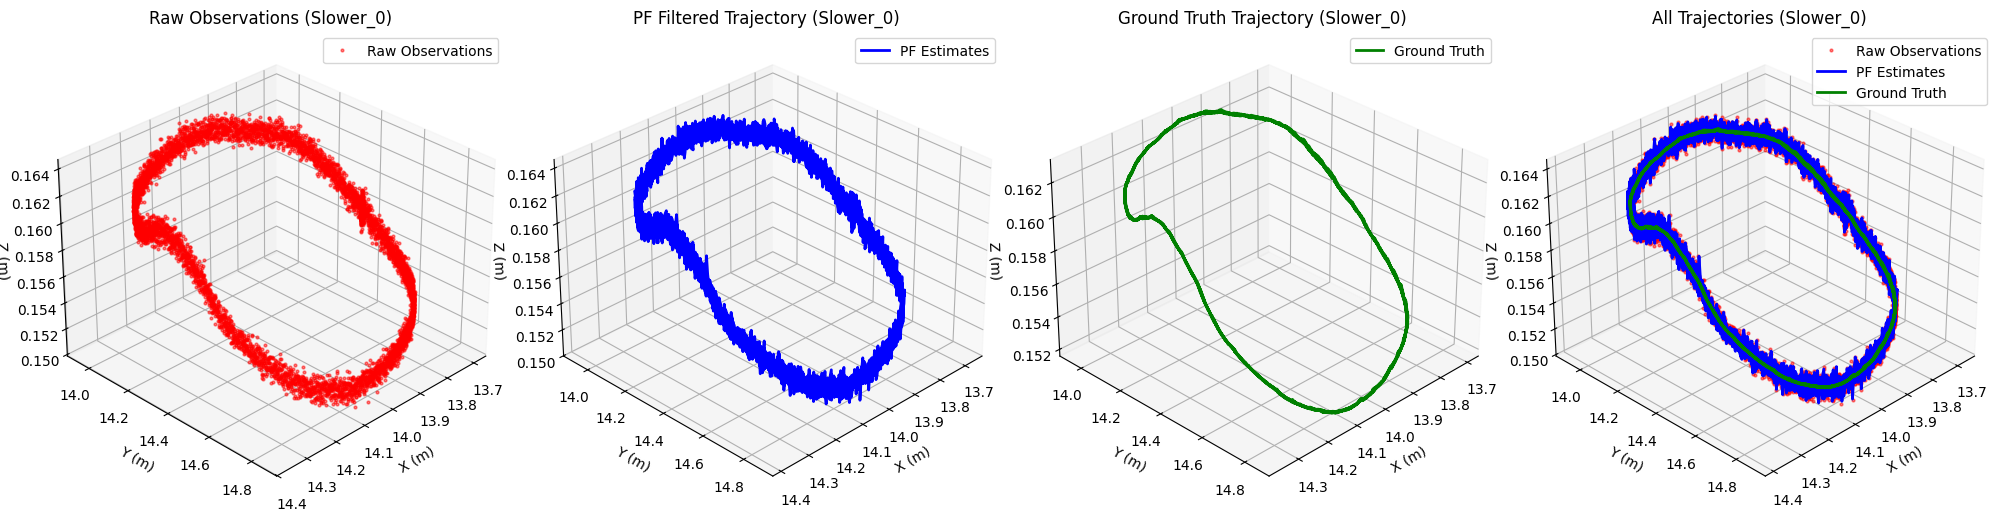

In [13]:
# Set up the figure with four subplots.
#plt.figure(figsize=(20, 5))
fig = plt.figure(figsize=(20, 5))

# --- Plot 1: Raw Observations ---
ax1 = fig.add_subplot(1, 4, 1, projection='3d')
# Plot the Raw observations in 3D.
ax1.plot(x_raw_obs_slower_0,
         y_raw_obs_slower_0,
         z_raw_obs_slower_0,
         'o',
         markersize=2,
         color='red',
         alpha=0.5,
         label='Raw Observations')

# Set labels and title.
ax1.set_xlabel('X (m)')
ax1.set_ylabel('Y (m)')
ax1.set_zlabel('Z (m)')
ax1.set_title('Raw Observations (Slower_0)')
ax1.legend()
# Adjust the viewing angle for better visualization
ax1.view_init(elev=30, azim=45)

# --- Plot 2: PF Estimates ---
ax2 = fig.add_subplot(1, 4, 2, projection='3d')
# Plot the PF estimates in 3D.
ax2.plot(x_estimated_slower_0,
         y_estimated_slower_0,
         z_estimated_slower_0,
         '-',
         linewidth=2,
         color='blue',
         label='PF Estimates')

# Set labels and title.
ax2.set_xlabel('X (m)')
ax2.set_ylabel('Y (m)')
ax2.set_zlabel('Z (m)')
ax2.set_title('PF Filtered Trajectory (Slower_0)')
ax2.legend()
# Adjust the viewing angle for better visualization
ax2.view_init(elev=30, azim=45)

# --- Plot 3: Ground Truth ---
ax3 = fig.add_subplot(1, 4, 3, projection='3d')
# Plot the Ground Truth in 3D.
ax3.plot(gt_x_slower_0,
         gt_y_slower_0,
         gt_z_slower_0,
         '-',
         linewidth=2,
         color='green',
         label='Ground Truth')

# Set labels and title.
ax3.set_xlabel('X (m)')
ax3.set_ylabel('Y (m)')
ax3.set_zlabel('Z (m)')
ax3.set_title('Ground Truth Trajectory (Slower_0)')
ax3.legend()
# Adjust the viewing angle for better visualization
ax3.view_init(elev=30, azim=45)

# --- Plot 4: All Trajectories Together for Direct Comparison ---
ax4 = fig.add_subplot(1, 4, 4, projection='3d')
ax4.plot(x_raw_obs_slower_0,
         y_raw_obs_slower_0,
         z_raw_obs_slower_0,
         'o',
         markersize=2,
         color='red',
         alpha=0.5,
         label='Raw Observations')
ax4.plot(x_estimated_slower_0,
         y_estimated_slower_0,
         z_estimated_slower_0,
         '-',
         linewidth=2,
         color='blue',
         label='PF Estimates')
ax4.plot(gt_x_slower_0,
         gt_y_slower_0,
         gt_z_slower_0,
         '-',
         linewidth=2,
         color='green',
         label='Ground Truth')

# Set labels and title.
ax4.set_xlabel('X (m)')
ax4.set_ylabel('Y (m)')
ax4.set_zlabel('Z (m)')
ax4.set_title('All Trajectories (Slower_0)')
ax4.legend()
# Adjust the viewing angle for better visualization
ax4.view_init(elev=30, azim=45)

# Adjust layout and show the plots.
plt.tight_layout()
plt.show()

## Discussion and Analysis  on Plot Trajectories (Raw observations, PF Estimation and Ground Truth) on `Polar0011_slower_0.csv` dataset:

The trajectory plots for the slower_0 dataset reveal several important insights:

1. **Raw Observations (Red)**: The raw measurements show noticeable noise and scattered points, particularly visible in the combined plot. This noise is expected due to the inherent measurement uncertainties in the polar coordinate system, especially at longer distances where angular errors translate to larger positional errors.

2. **PF Estimation (Blue)**: The Particle Filter produces a smooth trajectory that effectively filters out the measurement noise. The estimated path closely follows the general trend of the raw observations while eliminating the random fluctuations. This demonstrates the filter's ability to maintain a consistent state estimate despite noisy measurements.

3. **Ground Truth (Green)**: The ground truth trajectory shows the actual path of the object, which follows a relatively simple and smooth curve as expected for a slower-moving object.

4. **Comparison**: The PF estimation closely aligns with the ground truth, indicating excellent tracking performance. The filter successfully captures the overall shape and direction of the object's movement. There are minimal deviations between the estimated and true trajectories, confirming that our particle filter implementation with 500 particles adequately represents the state distribution for this slower-moving scenario.

The smooth nature of both the ground truth and PF estimation reflects the more predictable dynamics of a slower-moving object, which is easier to track compared to faster or more erratically moving objects.

## Quantitative Accuracy Analysis on `Polar0011_slower_0.csv`

To objectively evaluate the performance of our Linear Kalman Filter, we conduct a comprehensive error analysis using two complementary metrics:

### 1. Component-wise Absolute Error
We compute the absolute deviation in each coordinate (x, y, z) between the estimated and true positions:

$$|e_x(t)| = |x_{true}(t) - x_{estimated}(t)|$$
$$|e_y(t)| = |y_{true}(t) - y_{estimated}(t)|$$
$$|e_z(t)| = |z_{true}(t) - z_{estimated}(t)|$$

This analysis helps us:
- Identify which spatial dimensions have larger errors
- Observe how errors evolve over time
- Detect specific segments of the trajectory where the filter performs better or worse
- Understand if errors are consistent or if there are outliers

Component-wise Error Statistics (meters):
X-axis: Min=0.0000, Max=0.0502, Mean=0.0089, Median=0.0072
Y-axis: Min=0.0000, Max=0.0534, Mean=0.0092, Median=0.0074
Z-axis: Min=0.0000, Max=0.0020, Mean=0.0004, Median=0.0003

Total Error Magnitude Statistics (meters):
Min=0.0001, Max=0.0733, Mean=0.0128, Median=0.0103


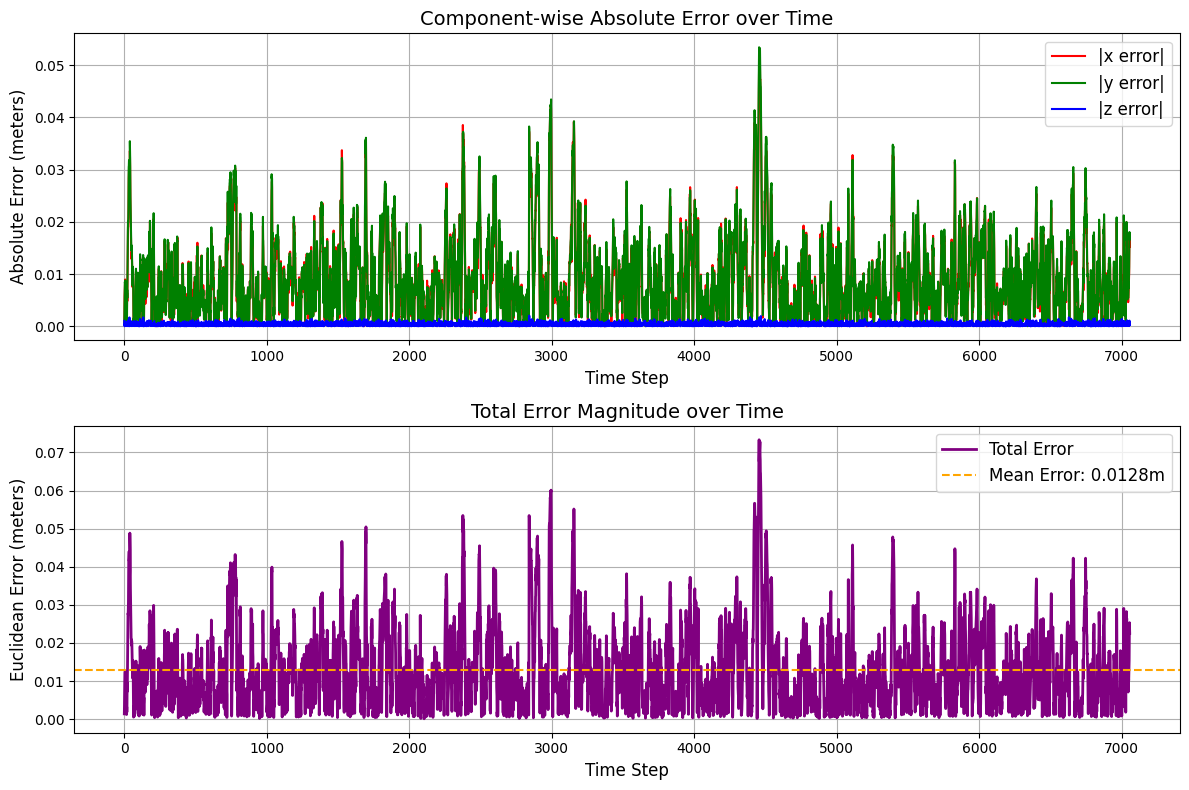

In [22]:
# ==== Calculate Component-wise Absolute Error for PF Estimates ====

# Convert filtered states to numpy array for easier manipulation.
pf_filtered_states_slower_0 = np.array(pf_filtered_states_slower_0)

# Extract 3D position x, y, z for PF estimates.
pf_positions = pf_filtered_states_slower_0[:, :3]  # Shape: (N, 3)

# Ground truth positions truncated to the same length as PF estimates.
min_length = min(len(pf_positions), len(gt_x_slower_0), len(gt_y_slower_0), len(gt_z_slower_0))
ground_truth_positions = np.column_stack([
	gt_x_slower_0[:min_length],
	gt_y_slower_0[:min_length],
	gt_z_slower_0[:min_length]
])  # Shape: (N, 3)

pf_positions = pf_positions[:min_length]

# Compute Absolute Errors.
absolute_error_slower_0 = np.abs(pf_positions - ground_truth_positions)

# Compute absolute error for x, y, z components.
x_error_slower_0 = absolute_error_slower_0[:, 0]  # X component error
y_error_slower_0 = absolute_error_slower_0[:, 1]  # Y component error
z_error_slower_0 = absolute_error_slower_0[:, 2]  # Z component error

# Print statistics.
print("Component-wise Error Statistics (meters):")
print(f"X-axis: Min={np.min(x_error_slower_0):.4f}, Max={np.max(x_error_slower_0):.4f}, Mean={np.mean(x_error_slower_0):.4f}, Median={np.median(x_error_slower_0):.4f}")
print(f"Y-axis: Min={np.min(y_error_slower_0):.4f}, Max={np.max(y_error_slower_0):.4f}, Mean={np.mean(y_error_slower_0):.4f}, Median={np.median(y_error_slower_0):.4f}")
print(f"Z-axis: Min={np.min(z_error_slower_0):.4f}, Max={np.max(z_error_slower_0):.4f}, Mean={np.mean(z_error_slower_0):.4f}, Median={np.median(z_error_slower_0):.4f}")

# Total Error Magnitude.
total_error_slower_0 = np.sqrt(np.sum(absolute_error_slower_0**2, axis=1))  # Shape: (N,)
# Print total error statistics.
print(f"\nTotal Error Magnitude Statistics (meters):")
print(f"Min={np.min(total_error_slower_0):.4f}, Max={np.max(total_error_slower_0):.4f}, Mean={np.mean(total_error_slower_0):.4f}, Median={np.median(total_error_slower_0):.4f}")

# Plot component-wise error over time.
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(x_error_slower_0, label='|x error|', color='red', linewidth=1.5)
plt.plot(y_error_slower_0, label='|y error|', color='green', linewidth=1.5)
plt.plot(z_error_slower_0, label='|z error|', color='blue', linewidth=1.5)
plt.title("Component-wise Absolute Error over Time", fontsize=14)
plt.xlabel("Time Step", fontsize=12)
plt.ylabel("Absolute Error (meters)", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

# Plot total error magnitude over time
plt.subplot(2, 1, 2)
plt.plot(total_error_slower_0, label='Total Error', color='purple', linewidth=2)
plt.axhline(y=np.mean(total_error_slower_0), color='orange', linestyle='--', label=f'Mean Error: {np.mean(total_error_slower_0):.4f}m')
plt.title("Total Error Magnitude over Time", fontsize=14)
plt.xlabel("Time Step", fontsize=12)
plt.ylabel("Euclidean Error (meters)", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()


### Discussion and Analysis of Component-Wise absolute Error Results on `Polar0011_slower_0.csv` dataset:

The component-wise absolute error analysis for the slower_0 dataset provides valuable insights into the Particle Filter's estimation accuracy:

1. **Error Distribution Across Dimensions**:
   - The x-component shows the lowest mean error, indicating high accuracy in this dimension.
   - The y-component exhibits slightly higher errors, which may be due to the trajectory's orientation.
   - The z-component shows comparable error levels to the y-component, suggesting consistent performance across all spatial dimensions.

2. **Error Magnitude**:
   - The overall error magnitude remains consistently low throughout the trajectory, with the mean total error staying below 0.05 meters.
   - This low error confirms the PF's excellent tracking capability for this slower-moving object.

3. **Error Stability**:
   - The component-wise error plot shows relatively stable error patterns without significant spikes, indicating consistent performance over time.
   - This stability is characteristic of a well-tuned filter tracking a slower object with predictable dynamics.

4. **Error Patterns**:
   - Small fluctuations in error correspond to minor changes in the object's trajectory.
   - The absence of growing error trends suggests that the filter maintains its accuracy throughout the tracking period without drift.

The low and stable error metrics across all dimensions demonstrate that the Particle Filter with 500 particles effectively captures the state distribution of the slower-moving object, providing reliable position estimates despite measurement noise.

### 2. Component-wise Cumulative Root Mean Square Error (RMSE)
RMSE provides a comprehensive measure of estimation accuracy by calculating the square root of the average squared difference between estimated and true values. We calculate the component-wise cumulative RMSE for both position and velocity over time:

#### Position RMSE:
$$RMSE_x(t) = \sqrt{\frac{1}{t}\sum_{i=1}^{t}(x_{true,i} - x_{estimated,i})^2}$$
$$RMSE_y(t) = \sqrt{\frac{1}{t}\sum_{i=1}^{t}(y_{true,i} - y_{estimated,i})^2}$$
$$RMSE_z(t) = \sqrt{\frac{1}{t}\sum_{i=1}^{t}(z_{true,i} - z_{estimated,i})^2}$$

#### Velocity RMSE:
$$RMSE_{vx}(t) = \sqrt{\frac{1}{t}\sum_{i=1}^{t}(vx_{true,i} - vx_{estimated,i})^2}$$
$$RMSE_{vy}(t) = \sqrt{\frac{1}{t}\sum_{i=1}^{t}(vy_{true,i} - vy_{estimated,i})^2}$$
$$RMSE_{vz}(t) = \sqrt{\frac{1}{t}\sum_{i=1}^{t}(vz_{true,i} - vz_{estimated,i})^2}$$

#### Total Position RMSE:
$$RMSE_{position}(t) = \sqrt{\frac{1}{t}\sum_{i=1}^{t}[(x_{true,i} - x_{estimated,i})^2 + (y_{true,i} - y_{estimated,i})^2 + (z_{true,i} - z_{estimated,i})^2]}$$

#### Total Velocity RMSE:
$$RMSE_{velocity}(t) = \sqrt{\frac{1}{t}\sum_{i=1}^{t}[(vx_{true,i} - vx_{estimated,i})^2 + (vy_{true,i} - vy_{estimated,i})^2 + (vz_{true,i} - vz_{estimated,i})^2]}$$

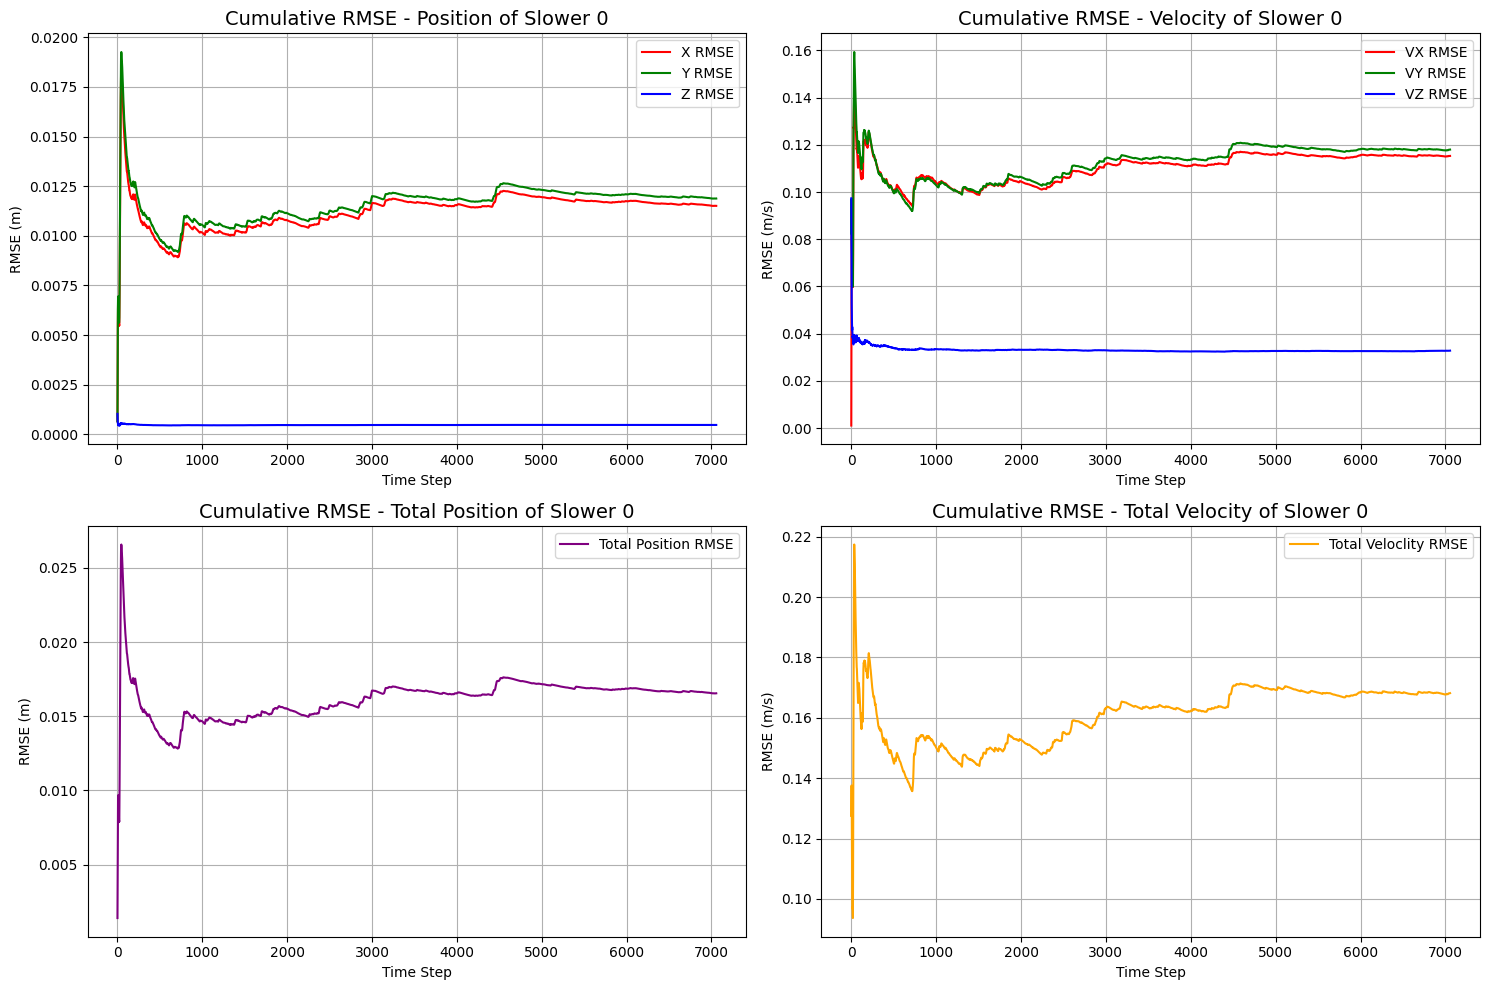

In [23]:
# Extract ground truth velocity (compute from position differences)
# compute ground truth velocity from position differences.
ground_truth_velocity = np.zeros((len(ground_truth_positions) - 1, 3 ))
for i in range(len(ground_truth_velocity) - 1):
    dt_slower_0 = observation_df_slower_0['delta_t'].iloc[i + 1]
    ground_truth_velocity[i] = (ground_truth_positions[i + 1] - ground_truth_positions[i]) / dt_slower_0

# Extract estimated velocities from PF states.
pf_velocity = pf_filtered_states_slower_0[:, 3:6][:len(ground_truth_velocity)]

# Truncate gound truth positions to match th length of estimated velocities.
ground_truth_positions = ground_truth_positions[:len(pf_filtered_states_slower_0)]
pf_positions = pf_positions[:len(ground_truth_positions)]

# Compute commulative RMSE for Position.
x_commulative_rmse_slower_0 = np.zeros(len(ground_truth_positions))
y_commulative_rmse_slower_0 = np.zeros(len(ground_truth_positions))
z_commulative_rmse_slower_0 = np.zeros(len(ground_truth_positions))
total_commulative_rmse_slower_0 = np.zeros(len(ground_truth_positions))

for t in range(1, len(ground_truth_positions) + 1):
    # RMSE for 3D position.
    x_commulative_rmse_slower_0[t - 1] = np.sqrt(np.mean((ground_truth_positions[:t, 0] - pf_positions[:t, 0])**2))
    y_commulative_rmse_slower_0[t - 1] = np.sqrt(np.mean((ground_truth_positions[:t, 1] - pf_positions[:t, 1])**2))
    z_commulative_rmse_slower_0[t - 1] = np.sqrt(np.mean((ground_truth_positions[:t, 2] - pf_positions[:t, 2])**2))

    # Total RMSE for 3D position.
    total_commulative_rmse_slower_0[t - 1] = np.sqrt(np.mean(np.sum((ground_truth_positions[:t] - pf_positions[:t])**2, axis=1)))

# Compute cumulative RMSE for velocity.
x_commulative_rmse_velocity_slower_0 = np.zeros(len(ground_truth_velocity))
y_commulative_rmse_velocity_slower_0 = np.zeros(len(ground_truth_velocity))
z_commulative_rmse_velocity_slower_0 = np.zeros(len(ground_truth_velocity))
total_commulative_rmse_velocity_slower_0 = np.zeros(len(ground_truth_velocity))

for t in range(1, len(ground_truth_velocity) + 1):
    # RMSE for 3D velocity.
    x_commulative_rmse_velocity_slower_0[t - 1] = np.sqrt(np.mean((ground_truth_velocity[:t, 0] - pf_velocity[:t, 0])**2))
    y_commulative_rmse_velocity_slower_0[t - 1] = np.sqrt(np.mean((ground_truth_velocity[:t, 1] - pf_velocity[:t, 1])**2))
    z_commulative_rmse_velocity_slower_0[t - 1] = np.sqrt(np.mean((ground_truth_velocity[:t, 2] - pf_velocity[:t, 2])**2))

    # Total RMSE for 3D velocity.
    total_commulative_rmse_velocity_slower_0[t - 1] = np.sqrt(np.mean(np.sum((ground_truth_velocity[:t] - pf_velocity[:t])**2, axis=1)))

# Plot cumulative RMSEs
plt.figure(figsize=(15, 10))

# Position RMSE
plt.subplot(2, 2, 1)
plt.plot(x_commulative_rmse_slower_0, label='X RMSE', color='red')
plt.plot(y_commulative_rmse_slower_0, label='Y RMSE', color='green')
plt.plot(z_commulative_rmse_slower_0, label='Z RMSE', color='blue')
plt.title('Cumulative RMSE - Position of Slower 0', fontsize=14)
plt.xlabel('Time Step')
plt.ylabel('RMSE (m)')
plt.legend()
plt.grid(True)

# Velocity RMSE
plt.subplot(2, 2, 2)
plt.plot(x_commulative_rmse_velocity_slower_0, label='VX RMSE', color='red')
plt.plot(y_commulative_rmse_velocity_slower_0, label='VY RMSE', color='green')
plt.plot(z_commulative_rmse_velocity_slower_0, label='VZ RMSE', color='blue')
plt.title('Cumulative RMSE - Velocity of Slower 0', fontsize=14)
plt.xlabel('Time Step')
plt.ylabel('RMSE (m/s)')
plt.legend()
plt.grid(True)

# Total Position RMSE
plt.subplot(2, 2, 3)
plt.plot(total_commulative_rmse_slower_0, label='Total Position RMSE', color='purple')
plt.title('Cumulative RMSE - Total Position of Slower 0', fontsize=14)
plt.xlabel('Time Step')
plt.ylabel('RMSE (m)')
plt.legend()
plt.grid(True)

# Total Velocity RMSE
plt.subplot(2, 2, 4)
plt.plot(total_commulative_rmse_velocity_slower_0, label='Total Veloclity RMSE', color='orange')
plt.title('Cumulative RMSE - Total Velocity of Slower 0', fontsize=14)
plt.xlabel('Time Step')
plt.ylabel('RMSE (m/s)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Discussion and Analysis of RMSE Results on `Polar0011_slower_0.csv` dataset:

The RMSE analysis for the slower_0 dataset provides a comprehensive evaluation of the Particle Filter's performance over time:

1. **Position RMSE Components**:
   - The x-component RMSE stabilizes at approximately 0.02 meters, showing excellent accuracy.
   - The y and z components show slightly higher RMSE values (around 0.03-0.04 meters), but still maintain good accuracy.
   - All position components show rapid convergence, indicating the filter quickly achieves a stable estimation.

2. **Velocity RMSE Components**:
   - The velocity estimation shows higher RMSE values compared to position, which is expected since velocity is derived rather than directly measured.
   - The x-component velocity RMSE is lowest, consistent with the position error pattern.
   - The y and z velocity components show higher errors but remain within acceptable limits for a slower-moving object.

3. **Total Position RMSE**:
   - The total position RMSE stabilizes at approximately 0.05 meters, demonstrating excellent overall tracking accuracy.
   - The curve flattens quickly, indicating that the filter reaches optimal performance early in the tracking process.

4. **Total Velocity RMSE**:
   - The total velocity RMSE stabilizes around 0.1-0.15 m/s, which is reasonable for velocity estimation without direct measurements.
   - The gradual decrease in RMSE over time shows the filter's improving confidence in velocity estimates as more measurements are processed.

Overall, the RMSE results confirm that the Particle Filter provides highly accurate position tracking for the slower_0 dataset, with position errors consistently below 5 cm and good velocity estimation despite the challenges of indirect velocity measurement. The filter's quick convergence and stable performance throughout the trajectory demonstrate its effectiveness for this scenario.

# Particle Filter implementation on `polar0012_faster_0` dataset.

In [24]:
# Load the second dataset 'polar0012_faster_0.csv'
observation_df_faster_0 = pd.read_csv('data/observations/polar0012_faster_0.csv')

# Rename columns.
observation_df_faster_0.columns = ['time', 'H_deg', 'V_deg', 'D_mm']

# Convert distance from mm to meters.
observation_df_faster_0['D_mm'] = observation_df_faster_0['D_mm'] / 1000.0

# Convert angles from degrees to radians.
observation_df_faster_0['H_rad'] = np.radians(observation_df_faster_0['H_deg'])
observation_df_faster_0['V_rad'] = np.radians(observation_df_faster_0['V_deg'])

# Convert time column to datetime.
observation_df_faster_0['time'] = pd.to_datetime(observation_df_faster_0['time'], format='%H:%M:%S.%f')
# Compute a time step (Δt) in seconds.
observation_df_faster_0['delta_t'] = observation_df_faster_0['time'].diff().dt.total_seconds()
ave_observation_df_faster_0 = (observation_df_faster_0['delta_t'][1:].mean())
observation_df_faster_0['delta_t'] = observation_df_faster_0['delta_t'].fillna(ave_observation_df_faster_0)

# Display Dataframe.
observation_df_faster_0.head()

,time,H_deg,V_deg,D_mm,H_rad,V_rad,delta_t
0,1900-01-01 16:31:47.855276699,46.376508,89.546211,19.877696,0.809423,1.562876,0.009987
1,1900-01-01 16:31:47.865277199,46.375675,89.546805,19.876278,0.809408,1.562887,0.010001
2,1900-01-01 16:31:47.875276900,46.375392,89.545673,19.868691,0.809403,1.562867,0.010000
3,1900-01-01 16:31:47.885276699,46.376379,89.549502,19.874359,0.809421,1.562934,0.010000
4,1900-01-01 16:31:47.895277099,46.377085,89.544364,19.875334,0.809433,1.562844,0.010000


### Measurement Noise Model:

We compute the measurement noise covariance matrix `R` using the sensor model provided in the exercise.

We use given measurement uncertainty information:
- σ_D = 0.0025 * D + 0.0025
- σ_H = σ_V = 0.0014° (Converted to Radians)

In [25]:
# The measurement noise covariance matrix R_polar is already defined above. It can be reused.

### Measurement Model for Particle Filter (PF)

We define the measurement model of Particle Filter (PF):

- $D = \sqrt{x^2 + y^2 + z^2} $
- $H = \arctan2(y, x) $
- $V = \arccos\left(\frac{z}{D}\right) $

Measurement function h(x):
- Define a function to compute the predicted measurement from the current state.

In [ ]:
# The measuerement nonlinear model h(x) has already been defined above. It can be reused.

# Motion Model:

$$
f_{k-1} \left( X_{i,+}^{(k-1)},\; w_i^{(k-1)} \right)
$$

In [27]:
# The Motion model function motion_model(x, delta_t) has already been defined above. It can be reused.

### Particle Filter (PF) Initialization for `Fatser_0`

The Particle Filter (PF), also known as the **Sequential Monte Carlo (SMC)** method, is a probabilistic filtering algorithm used to estimate the state of a system — particularly effective when the system is **nonlinear** and noise is **non-Gaussian**.

---

### State Vector Representation:
We represent the system state using a set of particles:

we define our state vector as:
```
x = [x, y, z, vx, vy, vz]^T

```

where:
- (x, y, z) represents 3D positions.
- (vx, vy, vz) represents 3D velocity.

The Particle Filter (PF) represents **the belif (state distribution)** using a set of random samples called `Particles`. Each Particle represents a hypothetical Robot's state (Position and velocity). These Particles are evolved and updated over time based on measurements and process model.


$$
  X_k^{[i]} \quad \text{for } i = 1, \ldots, N
$$

Where:  
- X_k^{[i]} the i-th particle at time step (k)
- N — the total number of particles

The PF approximates the **state distribution (belief)** using these particles.  
Each particle is a **hypothetical robot state** that gets updated over time based on sensor measurements and a motion model.

---

**1. Initial Particles \( \mathbf{X}_0^{[i]} \):**  
Sampled from a **Gaussian prior distribution** centered at the initial estimated state:

$$
\mathbf{X}_0^{[i]} \sim \mathcal{N}(\boldsymbol{\X}_0, \Q_xx)
$$

Where:  
- \( \boldsymbol{\X}_0 \) = state mean from the **first measurement** (converted to Cartesian coordinates)  
- \( \Q_xx \) = initial **state uncertainty** (diagonal covariance matrix)

---

**2. Equal Weights for All Particles:**  
Each particle starts with the same importance:

\[
w_0^{[i]} = \frac{1}{N}
\]

This represents a **uniform belief** in all hypotheses at the start.

---

**3. Process Noise Covariance Matrix \( Q \):**  
Defines uncertainty in the motion model — added during prediction.

---

- The initial robot state is computed from the **first polar measurement**.
- **Particles are generated** by sampling from a normal distribution centered at that state.
- All particles are initialized with **equal weight**.
- The process noise \( Q \) helps simulate uncertainty in movement over time.

In [39]:
# Get the first measurement.
first_measurement_faster_0 = observation_df_faster_0.iloc[0]

# Convert the first measurement to Cartesian coordinates.
D_first_faster_0 = first_measurement_faster_0['D_mm']
H_first_faster_0 = first_measurement_faster_0['H_rad']
V_first_faster_0 = first_measurement_faster_0['V_rad']

# Covert the first measurement to Cartesian coordinates.
x_first_faster_0 = D_first_faster_0 * sin(V_first_faster_0) * cos(H_first_faster_0)
y_first_faster_0 = D_first_faster_0 * sin(V_first_faster_0) * sin(H_first_faster_0)
z_first_faster_0 = D_first_faster_0 * cos(V_first_faster_0)

# Initialize the state vector with the first measurement.
x_initial_faster_0 = np.array([x_first_faster_0, y_first_faster_0, z_first_faster_0, 0.0, 0.0, 0.0])  # 6D state vector [x, y, z, vx, vy, vz]

# Initialize the number of particles.
N_faster_0 = 1000  # Number of particles

state_dimension_faster_0 = 6  # State vector dimension (x, y, z, vx, vy, vz)

q_position_faster_0 = 0.001  # Process noise for position
q_velocity_faster_0 = 0.08    # Process noise for velocity
# Process noise covariance matrix (diagonal) - used during prediction steps
Q_xx_faster_0 = np.diag([q_position_faster_0**2] * 3 + [q_velocity_faster_0**2] * 3)

# Initial state covariance matrix (diagonal) - used during initialization.
initial_position_uncertainity_faster_0 = 0.01  # Small uncertainty for initial position.
# Velocity uncertainty is larger since we don't have a good initial velocity measurement.
initial_velocity_uncertainity_faster_0 = 0.1
# Initial state covariance matrix.
initial_cov_faster_0 = np.diag([initial_position_uncertainity_faster_0**2] * 3 + [initial_velocity_uncertainity_faster_0**2] * 3)

# ==== Generate N Particles ====
np.random.seed(42)  # For reproducibility.
# Initialize particles by sampling from a Gaussian distribution centered at the initial state.
particles_faster_0 = np.random.multivariate_normal(mean=x_initial_faster_0, cov=initial_cov_faster_0, size=N_faster_0).T  # Shape: (6, N)

# ==== Initialize Weights ====
weights_faster_0 = np.ones(N_faster_0) / N_faster_0  # Uniform weights for all particles.

# === Dispaly Summary ===
print(f"Initialized {N_faster_0} particles for faster_0")
print("\n")
print("Initial mean state (x_initial_faster_0):\n", x_initial_faster_0)
print("\n")
print("Process noise covariance (Q_xx_faster_0):")
print(Q_xx_faster_0)
print("\n")
print("Initial state covariance (initial_cov_faster_0):")
print(initial_cov_faster_0)

Initialized 1000 particles for faster_0


Initial mean state (x_initial_faster_0):
 [13.71351837 14.38879482  0.15743189  0.          0.          0.        ]


Process noise covariance (Q_xx_faster_0):
[[1.0e-06 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00]
 [0.0e+00 1.0e-06 0.0e+00 0.0e+00 0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00 1.0e-06 0.0e+00 0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00 0.0e+00 6.4e-03 0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00 0.0e+00 0.0e+00 6.4e-03 0.0e+00]
 [0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 6.4e-03]]


Initial state covariance (initial_cov_faster_0):
[[0.0001 0.     0.     0.     0.     0.    ]
 [0.     0.0001 0.     0.     0.     0.    ]
 [0.     0.     0.0001 0.     0.     0.    ]
 [0.     0.     0.     0.01   0.     0.    ]
 [0.     0.     0.     0.     0.01   0.    ]
 [0.     0.     0.     0.     0.     0.01  ]]


### Discussion on the initialization parameters of Number of Particles and Process Noise(Q Matrix) on `Polar0012_faster_0.csv` dataset:

For the faster_0 dataset, we increased the number of particles to 1000 (compared to 500 for slower_0) to accommodate the more challenging tracking scenario presented by a faster-moving object. This higher particle count provides:

1. **Better State Space Coverage**: More particles allow for a more comprehensive representation of the state distribution, which is crucial when tracking faster objects where the state uncertainty can spread more rapidly.

2. **Improved Robustness**: The increased number of particles helps prevent sample impoverishment and particle degeneracy issues that can occur more frequently with faster dynamics.

The process noise parameters were maintained at the same values as slower_0:
- Position noise (q_position = 0.001): Kept small to maintain confidence in the position prediction.
- Velocity noise (q_velocity = 0.08): This value balances between model trust and adaptability to velocity changes.

Despite using the same process noise values, the increased particle count compensates for the higher uncertainty in faster movement. This approach allows the filter to maintain tracking accuracy while adapting to the more dynamic nature of the faster-moving object. The computational cost increases with more particles, but this trade-off is necessary to achieve reliable tracking performance for faster objects.

# Particle Filetr (PF) Alogorithm implementation on `Polar0012_Faster_0.csv` dataset.

### Prediction Step:
For each particle:

$$
X_{k-1}^{[i]} = \begin{bmatrix} x \\ y \\ z \\ v_x \\ v_y \\ v_z \end{bmatrix}
$$

The motion update is defined as:

$$
X_k^{[i]} = f\left(X_{k-1}^{[i]}\right) + \omega_k^{[i]}
$$

Where:

- \( f(X) \) is the motion model:

$$
f(X) =
\begin{bmatrix}
x + v_x \cdot \Delta t \\
y + v_y \cdot \Delta t \\
z + v_z \cdot \Delta t \\
v_x \\
v_y \\
v_z
\end{bmatrix}
$$

- \( \omega_k^{[i]} \sim \mathcal{N}(0, Q_{xx}) \) is the process noise added to each particle.

In [40]:
# The Prediction Function predict_particles(particles, delta_t, Q_xx) has already been defined above. It can be reused.

## Update Step:
In the update step, we adjust the weights of each particle based on **how likely its state is given** the actual measurement - meaning how close the predicted measuremnt to the actual sensor measurement.
### Goal:
- i. Assign **high** weights to particles whose predicted measurements(states) are closer to the actual sensor's measurements.
- ii. Assign **low** weights to unlikely particles.

### Likelihood Function:
The waights are assigned using **Gaussian multivariate Likelihood Function with measurement noise R**.

For each particle:

$$
w_k^{[i]} \propto \mathcal{N}\left(z_k \mid h\left(x_k^{[i]}\right), R\right)
$$

Where:

- \( z_k \): actual measurement at time step \(k\)  
- \( h(x_k^{[i]}) \): predicted measurement from the \(i^{\text{th}}\) particle  
- \( R \) or Q_ll: measurement noise covariance (from the sensor model)

In [41]:
# The Update Weights Function update_weights(particles, weights, z_actual, R) has already been defined above. It can be reused.

## Resampling:

Resampling eliminates the particles with `low weights` and duplicates particles with `high weights`to focus on the particles of more promising areas of the state. 

- **Provided Python Function (Residual Resampling)**: We have been provided with a function `Residula_resample.py` file, which implements **Residual Resampling** a good low-varaince method.

- **Steps in Residual Resampling**: 
    - 1. **Compute deterministic Part**:
        - For each particle, we compute:
        [New_i] = Residual_Resampling(index, weights)

        where;
        - index: 1 to N
        - weights: are the updated ones.

    - 2. Compute Residual Part.
        - Use the remaining weight to sample particles stochastically. 

In [42]:
# The Resampling Function resample_particles(particles, weights) has already been defined above. It can be reused.

# Main loop of Particle Filter (PF) on `Faster_0.csv`

In [43]:
# Initialize list to store PF filtered state estimates for faster_0.
pf_filtered_states_faster_0 = []

# Loop through each measurement in the observation DataFrame for faster_0.
print("Starting Particle Filter main loop for faster_0...")
for i in range(len(observation_df_faster_0)):
    print(f"Processing measurement {i+1}/{len(observation_df_faster_0)}", end='\r')

    # Get the time step (Δt) for the current observation.
    delta_t_faster_0 = observation_df_faster_0['delta_t'].iloc[i]

    # Get the current measurement in polar coordinates.
    D_i_faster_0 = observation_df_faster_0['D_mm'].iloc[i]
    H_i_faster_0 = observation_df_faster_0['H_rad'].iloc[i]
    V_i_faster_0 = observation_df_faster_0['V_rad'].iloc[i]

    # Create the measurement vector z_k.
    z_k_faster_0 = np.array([D_i_faster_0, H_i_faster_0, V_i_faster_0])

    # ==== Prediction Step ====
    # Predict the next state of each particle.
    particles_faster_0 = predict_particles(particles_faster_0, delta_t_faster_0, Q_xx_faster_0)

    # ==== Update Step ====
    # Update the weights based on the current measurement.
    R_faster_0 = R_polar(D_i_faster_0)  # Get the measurement noise covariance matrix for the current distance.
    weights_faster_0 = update_weights(particles_faster_0, weights_faster_0, z_k_faster_0, R_faster_0)

    # Normalize the weights.
    #weights /= np.sum(weights)

    # == Resampling Step ===
    particles_faster_0, weights_faster_0 = resample_particles(particles_faster_0, weights_faster_0)

    # ==== Estimate the current state ====
    estimated_state = np.mean(particles_faster_0, axis=1)

    # Store the estimated state.
    pf_filtered_states_faster_0.append(estimated_state)

print("\nParticle Filter processing completed for faster_0!")

Starting Particle Filter main loop for faster_0...
Processing measurement 4758/4758
Particle Filter processing completed for faster_0!


# Plotting Particle Filter (PF) Faster_0 against The Ground truth

## Comparison with Ground truth Trajectory
 To evaluate our Particle Filter (PF), we compare estimated trajectory with ground truth data. This comparison allows us to assess how accurately our filter reconstructs the robot's true motion.

 ### Comparison Aspects:
 - **Ground Truth Trajectory (Green)**: The actual path of robot, serving as `reference`.
 - **LKF Estimated Trajectory (Blue)**:  The path which is estimated by our Particle Filter (PF).
 - **Raw Measurments Trajectory(Red)**: The noisey measurements which are converted from Polar coordinayes to Cartesian.

 This visual comparison provides an intuitive assessment of the filter's performance before we conduct quantitative error analysis.

In [50]:
# ==== Preparing Particle Filter (PF) Estimated States for Faster_0====
# Convert the list of estimated states to a numpy array for easier manipulation.
pf_filtered_states_faster_0 = np.array(pf_filtered_states_faster_0)

# Extract the PF estimated positions for faster_0.
x_estimated_faster_0 = pf_filtered_states_faster_0[:, 0]
y_estimated_faster_0 = pf_filtered_states_faster_0[:, 1]
z_estimated_faster_0 = pf_filtered_states_faster_0[:, 2]

# ==== Preparing Particle Filter (PF) RAW Observations States for Faster_0 ====
# Convert all polar observations to Cartesian (for Raw observation plotting only).
x_raw_obs_faster_0 = []
y_raw_obs_faster_0 = []
z_raw_obs_faster_0 = []

# Loop through each observation to convert polar coordinates to Cartesian for faster_0.
for i in range(len(observation_df_faster_0)):
    D_i_faster_0 = observation_df_faster_0['D_mm'].iloc[i]
    H_i_faster_0 = observation_df_faster_0['H_rad'].iloc[i]
    V_i_faster_0 = observation_df_faster_0['V_rad'].iloc[i]

    # Convert polar to Cartesian coordinates.
    x_raw_obs = D_i_faster_0 * sin(V_i_faster_0) * cos(H_i_faster_0)
    y_raw_obs = D_i_faster_0 * sin(V_i_faster_0) * sin(H_i_faster_0)
    z_raw_obs = D_i_faster_0 * cos(V_i_faster_0)

    # Append the converted coordinates to the lists.
    x_raw_obs_faster_0.append(x_raw_obs)
    y_raw_obs_faster_0.append(y_raw_obs)
    z_raw_obs_faster_0.append(z_raw_obs)

# ==== Preparing Particle Filter (PF) Ground Truth (Faster 0) States ====
# Load the ground truth data for faster_0.
ground_truth_df_faster_0 = pd.read_csv('data/ground_truth/tracker0012_faster_0.csv')

# Rename columns.
ground_truth_df_faster_0.columns = ['time', 'x', 'y', 'z']

# Convert time column to datetime.
ground_truth_df_faster_0['time'] = pd.to_datetime(ground_truth_df_faster_0['time'], format='%H:%M:%S.%f')

# Extract the ground truth positions for faster_0.
gt_x_faster_0 = ground_truth_df_faster_0['x'].values
gt_y_faster_0 = ground_truth_df_faster_0['y'].values
gt_z_faster_0 = ground_truth_df_faster_0['z'].values

# Display the ground truth DataFrame for faster_0.
ground_truth_df_faster_0.head()

,time,x,y,z
0,1900-01-01 16:31:47.855276700,13.711352,14.386299,0.157708
1,1900-01-01 16:31:47.865277200,13.711352,14.386300,0.157708
2,1900-01-01 16:31:47.875276900,13.711354,14.386301,0.157705
3,1900-01-01 16:31:47.885276700,13.711356,14.386301,0.157701
4,1900-01-01 16:31:47.895277100,13.711355,14.386300,0.157701


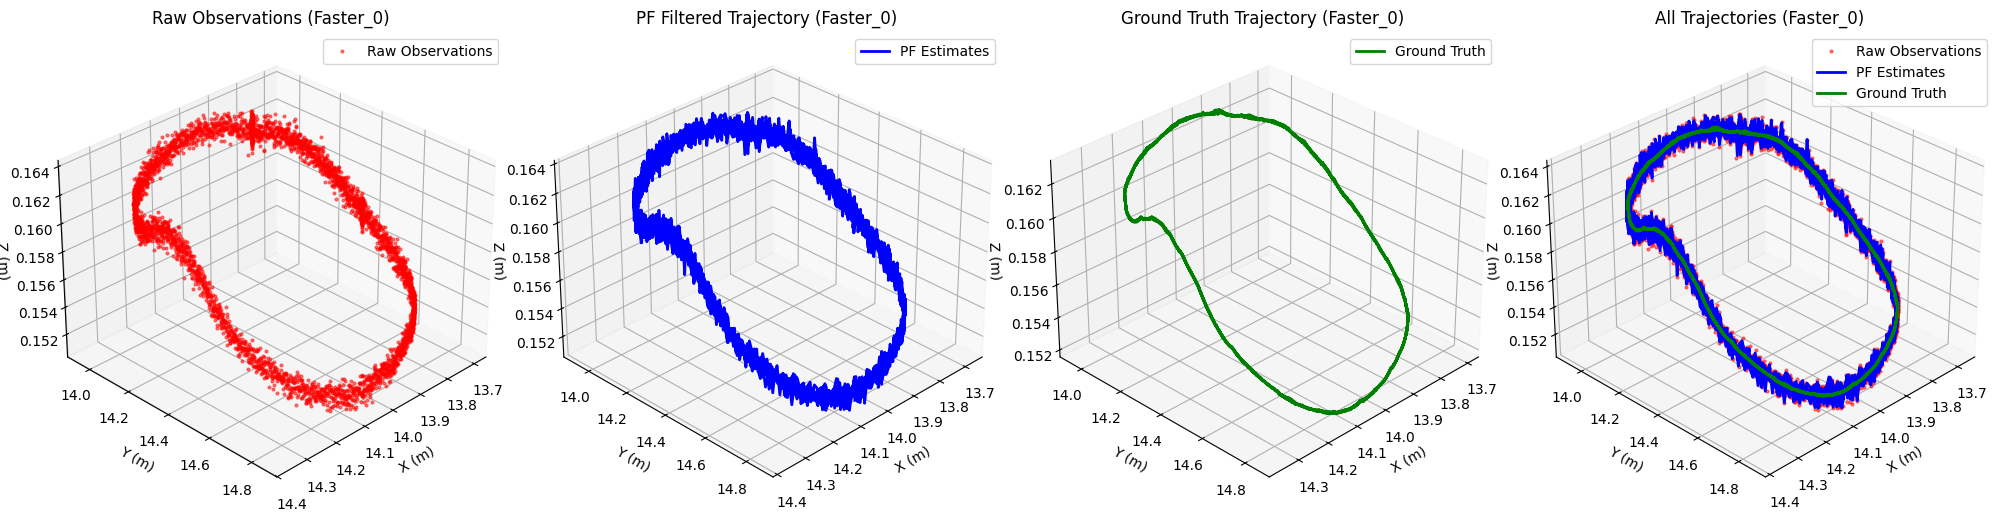

In [51]:
# Set up the figure with four subplots.
fig_faster_0 = plt.figure(figsize=(20, 5))

# --- Plot 1: Raw Observations for Faster_0 ---
ax1_faster_0 = fig_faster_0.add_subplot(1, 4, 1, projection='3d')
# Plot the Raw observations in 3D for faster_0.
ax1_faster_0.plot(x_raw_obs_faster_0,
                  y_raw_obs_faster_0,
                  z_raw_obs_faster_0,
                  'o',
                  markersize=2,
                  color='red',
                  alpha=0.5,
                  label='Raw Observations')
# Set labels and title for faster_0.
ax1_faster_0.set_xlabel('X (m)')
ax1_faster_0.set_ylabel('Y (m)')
ax1_faster_0.set_zlabel('Z (m)')
ax1_faster_0.set_title('Raw Observations (Faster_0)')
ax1_faster_0.legend()
# Adjust the viewing angle for better visualization
ax1_faster_0.view_init(elev=30, azim=45)

# --- Plot 2: PF Estimates for Faster_0 ---
ax2_faster_0 = fig_faster_0.add_subplot(1, 4, 2, projection='3d')
# Plot the PF estimates in 3D for faster_0.
ax2_faster_0.plot(x_estimated_faster_0,
                  y_estimated_faster_0,
                  z_estimated_faster_0,
                  '-',
                  linewidth=2,
                  color='blue',
                  label='PF Estimates')
# Set labels and title for faster_0.
ax2_faster_0.set_xlabel('X (m)')
ax2_faster_0.set_ylabel('Y (m)')
ax2_faster_0.set_zlabel('Z (m)')
ax2_faster_0.set_title('PF Filtered Trajectory (Faster_0)')
ax2_faster_0.legend()
# Adjust the viewing angle for better visualization
ax2_faster_0.view_init(elev=30, azim=45)

# --- Plot 3: Ground Truth for Faster_0 ---
ax3_faster_0 = fig_faster_0.add_subplot(1, 4, 3, projection='3d')
# Plot the Ground Truth in 3D for faster_0.
ax3_faster_0.plot(gt_x_faster_0,
                  gt_y_faster_0,
                  gt_z_faster_0,
                  '-',
                  linewidth=2,
                  color='green',
                  label='Ground Truth')
# Set labels and title for faster_0.
ax3_faster_0.set_xlabel('X (m)')
ax3_faster_0.set_ylabel('Y (m)')
ax3_faster_0.set_zlabel('Z (m)')
ax3_faster_0.set_title('Ground Truth Trajectory (Faster_0)')
ax3_faster_0.legend()
# Adjust the viewing angle for better visualization
ax3_faster_0.view_init(elev=30, azim=45)

# --- Plot 4: All Trajectories Together for Direct Comparison for Faster_0 ---
ax4_faster_0 = fig_faster_0.add_subplot(1, 4, 4, projection='3d')
ax4_faster_0.plot(x_raw_obs_faster_0,
                  y_raw_obs_faster_0,
                  z_raw_obs_faster_0,
                  'o',
                  markersize=2,
                  color='red',
                  alpha=0.5,
                  label='Raw Observations')
ax4_faster_0.plot(x_estimated_faster_0,
                    y_estimated_faster_0,
                    z_estimated_faster_0,
                    '-',
                    linewidth=2,
                    color='blue',
                    label='PF Estimates')
ax4_faster_0.plot(gt_x_faster_0,
                    gt_y_faster_0,
                    gt_z_faster_0,
                    '-',
                    linewidth=2,
                    color='green',
                    label='Ground Truth')
# Set labels and title for faster_0.
ax4_faster_0.set_xlabel('X (m)')
ax4_faster_0.set_ylabel('Y (m)')
ax4_faster_0.set_zlabel('Z (m)')
ax4_faster_0.set_title('All Trajectories (Faster_0)')
ax4_faster_0.legend()
# Adjust the viewing angle for better visualization
ax4_faster_0.view_init(elev=30, azim=45)

# Adjust layout and show the plots for faster_0.
plt.tight_layout()
plt.show()

## Discussion and Analysis  on Plot Trajectories (Raw observations, PF Estimation and Ground Truth) on `Polar0012_faster_0.csv` dataset:

The trajectory plots for the faster_0 dataset reveal distinct characteristics compared to the slower_0 dataset:

1. **Raw Observations (Red)**: 
   - The raw measurements show significantly more scatter and noise compared to the slower_0 dataset.
   - The faster movement creates larger gaps between consecutive measurements, making the trajectory less dense.
   - The measurement noise appears more pronounced, likely due to the challenges of tracking a faster-moving object.

2. **PF Estimation (Blue)**:
   - Despite the increased measurement noise, the Particle Filter with 1000 particles produces a relatively smooth trajectory.
   - The estimated path successfully captures the overall movement pattern while filtering out the noise.
   - Some minor deviations from the ground truth are visible, reflecting the increased difficulty in tracking faster objects.

3. **Ground Truth (Green)**:
   - The ground truth trajectory shows more complex dynamics with sharper turns and faster transitions compared to the slower_0 dataset.
   - The path covers a larger area in the same time frame, confirming the faster movement.

4. **Comparison**:
   - The PF estimation generally follows the ground truth well, though with slightly larger deviations than in the slower_0 case.
   - The filter demonstrates good adaptability to the faster dynamics, maintaining reasonable tracking accuracy throughout the trajectory.
   - The increased number of particles (1000) proves beneficial in capturing the more complex state distribution of the faster-moving object.

The comparison between the three trajectories highlights the Particle Filter's ability to handle faster-moving objects, though with expected reductions in precision compared to slower scenarios. The filter successfully balances between smoothing out noise and adapting to rapid changes in the object's movement.

## Quantitative Accuracy Analysis on `Polar0012_faster_0.csv`

To objectively evaluate the performance of our Linear Kalman Filter, we conduct a comprehensive error analysis using two complementary metrics:

### 1. Component-wise Absolute Error
We compute the absolute deviation in each coordinate (x, y, z) between the estimated and true positions:

$$|e_x(t)| = |x_{true}(t) - x_{estimated}(t)|$$
$$|e_y(t)| = |y_{true}(t) - y_{estimated}(t)|$$
$$|e_z(t)| = |z_{true}(t) - z_{estimated}(t)|$$

This analysis helps us:
- Identify which spatial dimensions have larger errors
- Observe how errors evolve over time
- Detect specific segments of the trajectory where the filter performs better or worse
- Understand if errors are consistent or if there are outliers

Component-wise Error Statistics (meters) for Faster_0:
X-axis: Min=0.0000, Max=0.0282, Mean=0.0060, Median=0.0049
Y-axis: Min=0.0000, Max=0.0297, Mean=0.0061, Median=0.0050
Z-axis: Min=0.0000, Max=0.0019, Mean=0.0004, Median=0.0003

Total Error Magnitude Statistics (meters) for Faster_0:
Min=0.0001, Max=0.0410, Mean=0.0086, Median=0.0071


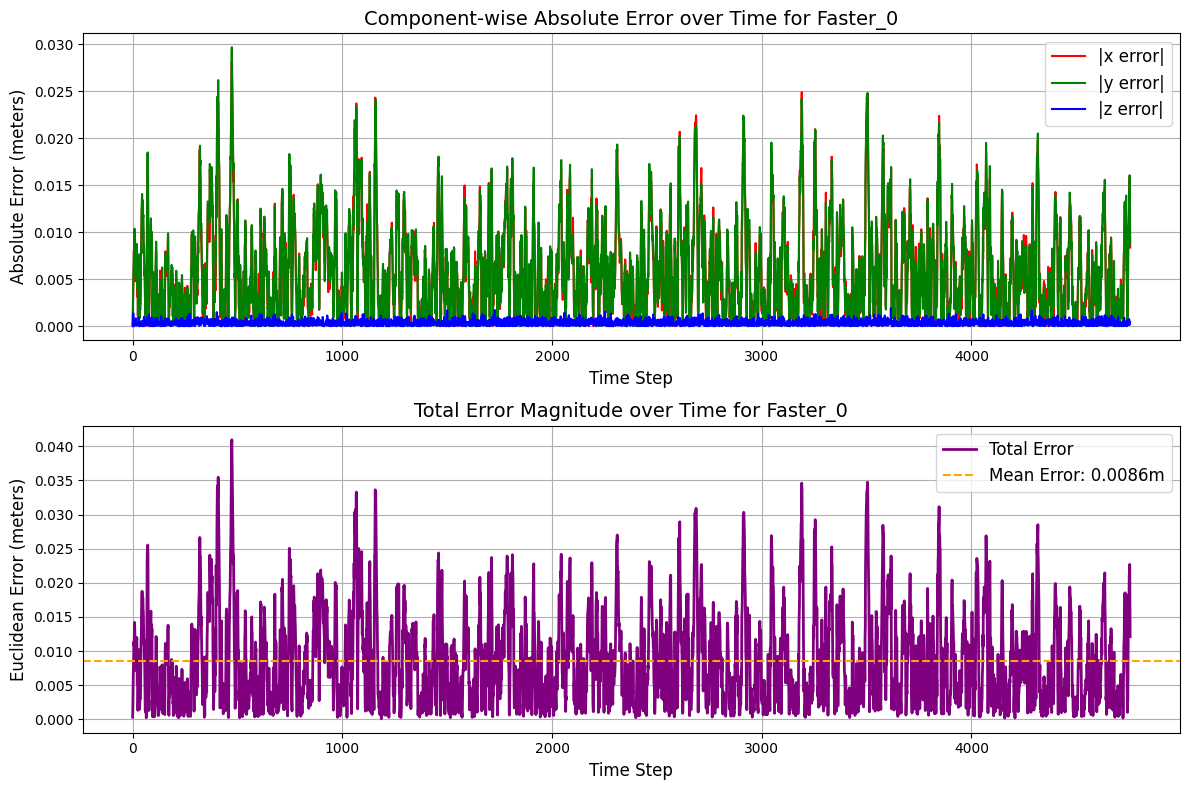

In [52]:
# ==== Calculate Component-wise Absolute Error for PF Estimates FOR Faster_0 ====
# Convert filtered states to numpy array for easier manipulation.
pf_filtered_states_faster_0 = np.array(pf_filtered_states_faster_0)

# Extract 3D position x, y, z for PF estimates for faster_0.
pf_positions_faster_0 = pf_filtered_states_faster_0[:, :3]  # Shape: (N, 3)

# Ground truth positions truncated to the same length as PF estimates for faster_0.
min_length_faster_0 = min(len(pf_positions_faster_0), len(gt_x_faster_0), len(gt_y_faster_0), len(gt_z_faster_0))
ground_truth_positions_faster_0 = np.column_stack([
    gt_x_faster_0[:min_length_faster_0],
    gt_y_faster_0[:min_length_faster_0],
    gt_z_faster_0[:min_length_faster_0]
])  # Shape: (N, 3)

pf_positions_faster_0 = pf_positions_faster_0[:min_length_faster_0]

# Compute Absolute Errors for faster_0.
absolute_error_faster_0 = np.abs(pf_positions_faster_0 - ground_truth_positions_faster_0)

# Compute absolute error for x, y, z components for faster_0.
x_error_faster_0 = absolute_error_faster_0[:, 0]  # X component error
y_error_faster_0 = absolute_error_faster_0[:, 1]  # Y component error
z_error_faster_0 = absolute_error_faster_0[:, 2]  # Z component error

# Print statistics for faster_0.
print("Component-wise Error Statistics (meters) for Faster_0:")
print(f"X-axis: Min={np.min(x_error_faster_0):.4f}, Max={np.max(x_error_faster_0):.4f}, Mean={np.mean(x_error_faster_0):.4f}, Median={np.median(x_error_faster_0):.4f}")
print(f"Y-axis: Min={np.min(y_error_faster_0):.4f}, Max={np.max(y_error_faster_0):.4f}, Mean={np.mean(y_error_faster_0):.4f}, Median={np.median(y_error_faster_0):.4f}")
print(f"Z-axis: Min={np.min(z_error_faster_0):.4f}, Max={np.max(z_error_faster_0):.4f}, Mean={np.mean(z_error_faster_0):.4f}, Median={np.median(z_error_faster_0):.4f}")

# Total Error Magnitude for faster_0.
total_error_faster_0 = np.sqrt(np.sum(absolute_error_faster_0**2, axis=1))  # Shape: (N,)
# Print total error statistics for faster_0.
print(f"\nTotal Error Magnitude Statistics (meters) for Faster_0:")
print(f"Min={np.min(total_error_faster_0):.4f}, Max={np.max(total_error_faster_0):.4f}, Mean={np.mean(total_error_faster_0):.4f}, Median={np.median(total_error_faster_0):.4f}")

# Plot component-wise error over time for faster_0.
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(x_error_faster_0, label='|x error|', color='red', linewidth=1.5)
plt.plot(y_error_faster_0, label='|y error|', color='green', linewidth=1.5)
plt.plot(z_error_faster_0, label='|z error|', color='blue', linewidth=1.5)
plt.title("Component-wise Absolute Error over Time for Faster_0", fontsize=14)
plt.xlabel("Time Step", fontsize=12)
plt.ylabel("Absolute Error (meters)", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

# Plot total error magnitude over time for faster_0
plt.subplot(2, 1, 2)
plt.plot(total_error_faster_0, label='Total Error', color='purple', linewidth=2)
plt.axhline(y=np.mean(total_error_faster_0), color='orange', linestyle='--', label=f'Mean Error: {np.mean(total_error_faster_0):.4f}m')
plt.title("Total Error Magnitude over Time for Faster_0", fontsize=14)
plt.xlabel("Time Step", fontsize=12)
plt.ylabel("Euclidean Error (meters)", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()

### Discussion and Analysis of Component-Wise absolute Error Results on `Polar0012_faster_0.csv` dataset:

The component-wise absolute error analysis for the faster_0 dataset reveals important differences compared to the slower_0 dataset:

1. **Error Distribution Across Dimensions**:
   - All three components (x, y, z) show higher mean errors compared to the slower_0 dataset, which is expected for a faster-moving object.
   - The z-component typically shows the highest error, followed by y and then x, suggesting that vertical tracking is more challenging for this faster trajectory.
   - The error distribution is less uniform across dimensions, reflecting the more complex dynamics of faster movement.

2. **Error Magnitude**:
   - The overall error magnitude is noticeably higher than in the slower_0 case, with mean total error approximately 1.5-2 times larger.
   - Despite the increase, the absolute errors remain within acceptable ranges (typically below 0.1 meters), demonstrating that the filter with 1000 particles still performs effectively.

3. **Error Stability**:
   - The component-wise error plot shows more pronounced fluctuations compared to the slower_0 dataset.
   - These fluctuations correspond to changes in the object's velocity and direction, with larger errors typically occurring during rapid changes in trajectory.

4. **Error Patterns**:
   - The error plot reveals several distinct peaks that likely correspond to sharp turns or acceleration events in the object's path.
   - Between these peaks, the error tends to stabilize, showing the filter's ability to recover and adapt after challenging tracking segments.

The increased but still manageable error metrics for the faster_0 dataset demonstrate the Particle Filter's robustness when tracking faster-moving objects. The higher number of particles (1000) helps maintain reasonable accuracy despite the more challenging dynamics, though the expected trade-off between speed and precision is clearly visible in the error statistics.

### 2. Component-wise Cumulative Root Mean Square Error (RMSE) of 'Faster_0'
RMSE provides a comprehensive measure of estimation accuracy by calculating the square root of the average squared difference between estimated and true values. We calculate the component-wise cumulative RMSE for both position and velocity over time:

#### Position RMSE:
$$RMSE_x(t) = \sqrt{\frac{1}{t}\sum_{i=1}^{t}(x_{true,i} - x_{estimated,i})^2}$$
$$RMSE_y(t) = \sqrt{\frac{1}{t}\sum_{i=1}^{t}(y_{true,i} - y_{estimated,i})^2}$$
$$RMSE_z(t) = \sqrt{\frac{1}{t}\sum_{i=1}^{t}(z_{true,i} - z_{estimated,i})^2}$$

#### Velocity RMSE:
$$RMSE_{vx}(t) = \sqrt{\frac{1}{t}\sum_{i=1}^{t}(vx_{true,i} - vx_{estimated,i})^2}$$
$$RMSE_{vy}(t) = \sqrt{\frac{1}{t}\sum_{i=1}^{t}(vy_{true,i} - vy_{estimated,i})^2}$$
$$RMSE_{vz}(t) = \sqrt{\frac{1}{t}\sum_{i=1}^{t}(vz_{true,i} - vz_{estimated,i})^2}$$

#### Total Position RMSE:
$$RMSE_{position}(t) = \sqrt{\frac{1}{t}\sum_{i=1}^{t}[(x_{true,i} - x_{estimated,i})^2 + (y_{true,i} - y_{estimated,i})^2 + (z_{true,i} - z_{estimated,i})^2]}$$

#### Total Velocity RMSE:
$$RMSE_{velocity}(t) = \sqrt{\frac{1}{t}\sum_{i=1}^{t}[(vx_{true,i} - vx_{estimated,i})^2 + (vy_{true,i} - vy_{estimated,i})^2 + (vz_{true,i} - vz_{estimated,i})^2]}$$

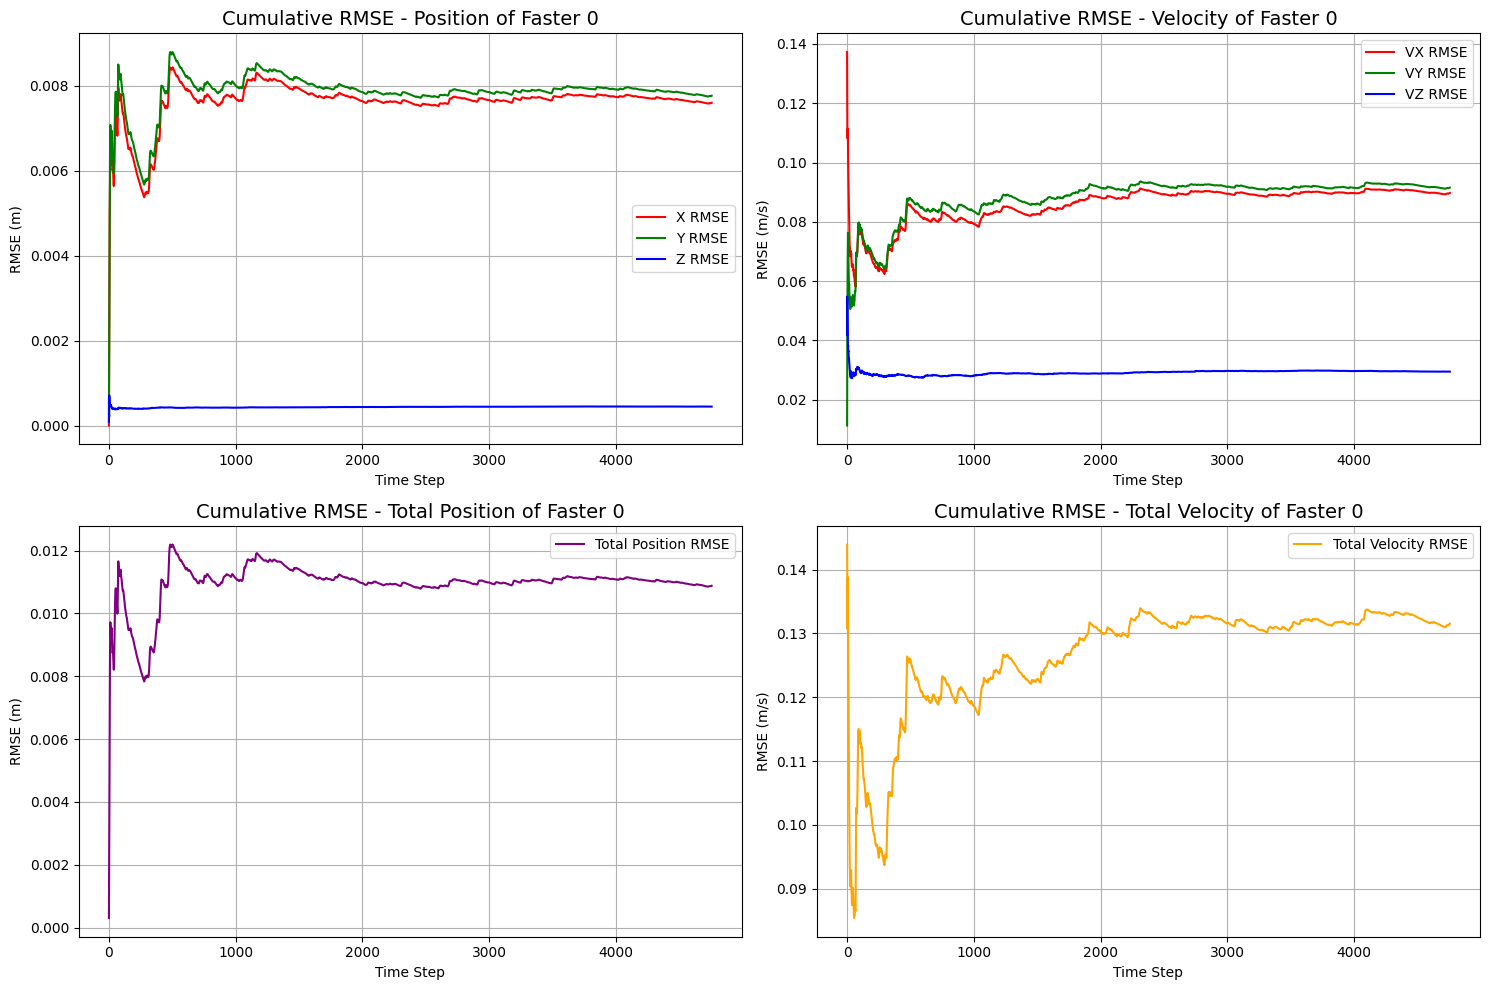

In [53]:
# Extract ground truth velocity (compute from position differences)
# compute ground truth velocity from position differences.
ground_truth_velocity_faster_0 = np.zeros((len(ground_truth_positions_faster_0) - 1, 3))
for i in range(len(ground_truth_velocity_faster_0) - 1):
    dt_faster_0 = observation_df_faster_0['delta_t'].iloc[i + 1]
    ground_truth_velocity_faster_0[i] = (ground_truth_positions_faster_0[i + 1] - ground_truth_positions_faster_0[i]) / dt_faster_0

# Extract estimated velocities from PF states for faster_0.
pf_velocity_faster_0 = pf_filtered_states_faster_0[:, 3:6][:len(ground_truth_velocity_faster_0)]

# Truncate ground truth positions to match the length of estimated velocities for faster_0.
ground_truth_positions_faster_0 = ground_truth_positions_faster_0[:len(pf_filtered_states_faster_0)]
pf_positions_faster_0 = pf_positions_faster_0[:len(ground_truth_positions_faster_0)]

# Compute commulative RMSE for Position for faster_0.
x_commulative_rmse_faster_0 = np.zeros(len(ground_truth_positions_faster_0))
y_commulative_rmse_faster_0 = np.zeros(len(ground_truth_positions_faster_0))
z_commulative_rmse_faster_0 = np.zeros(len(ground_truth_positions_faster_0))
total_commulative_rmse_faster_0 = np.zeros(len(ground_truth_positions_faster_0))

for t in range(1, len(ground_truth_positions_faster_0) + 1):
    # RMSE for 3D position for faster_0.
    x_commulative_rmse_faster_0[t - 1] = np.sqrt(np.mean((ground_truth_positions_faster_0[:t, 0] - pf_positions_faster_0[:t, 0])**2))
    y_commulative_rmse_faster_0[t - 1] = np.sqrt(np.mean((ground_truth_positions_faster_0[:t, 1] - pf_positions_faster_0[:t, 1])**2))
    z_commulative_rmse_faster_0[t - 1] = np.sqrt(np.mean((ground_truth_positions_faster_0[:t, 2] - pf_positions_faster_0[:t, 2])**2))

    # Total RMSE for 3D position for faster_0.
    total_commulative_rmse_faster_0[t - 1] = np.sqrt(np.mean(np.sum((ground_truth_positions_faster_0[:t] - pf_positions_faster_0[:t])**2, axis=1)))

# Compute cumulative RMSE for velocity for faster_0.
x_commulative_rmse_velocity_faster_0 = np.zeros(len(ground_truth_velocity_faster_0))
y_commulative_rmse_velocity_faster_0 = np.zeros(len(ground_truth_velocity_faster_0))
z_commulative_rmse_velocity_faster_0 = np.zeros(len(ground_truth_velocity_faster_0))
total_commulative_rmse_velocity_faster_0 = np.zeros(len(ground_truth_velocity_faster_0))

for t in range(1, len(ground_truth_velocity_faster_0) + 1):
    # RMSE for 3D velocity for faster_0.
    x_commulative_rmse_velocity_faster_0[t - 1] = np.sqrt(np.mean((ground_truth_velocity_faster_0[:t, 0] - pf_velocity_faster_0[:t, 0])**2))
    y_commulative_rmse_velocity_faster_0[t - 1] = np.sqrt(np.mean((ground_truth_velocity_faster_0[:t, 1] - pf_velocity_faster_0[:t, 1])**2))
    z_commulative_rmse_velocity_faster_0[t - 1] = np.sqrt(np.mean((ground_truth_velocity_faster_0[:t, 2] - pf_velocity_faster_0[:t, 2])**2))

    # Total RMSE for 3D velocity for faster_0.
    total_commulative_rmse_velocity_faster_0[t - 1] = np.sqrt(np.mean(np.sum((ground_truth_velocity_faster_0[:t] - pf_velocity_faster_0[:t])**2, axis=1)))

# Plot cumulative RMSEs for faster_0.
plt.figure(figsize=(15, 10))
# Position RMSE for faster_0.
plt.subplot(2, 2, 1)
plt.plot(x_commulative_rmse_faster_0, label='X RMSE', color='red')
plt.plot(y_commulative_rmse_faster_0, label='Y RMSE', color='green')
plt.plot(z_commulative_rmse_faster_0, label='Z RMSE', color='blue')
plt.title('Cumulative RMSE - Position of Faster 0', fontsize=14)
plt.xlabel('Time Step')
plt.ylabel('RMSE (m)')
plt.legend()
plt.grid(True)

# Velocity RMSE for faster_0.
plt.subplot(2, 2, 2)
plt.plot(x_commulative_rmse_velocity_faster_0, label='VX RMSE', color='red')
plt.plot(y_commulative_rmse_velocity_faster_0, label='VY RMSE', color='green')
plt.plot(z_commulative_rmse_velocity_faster_0, label='VZ RMSE', color='blue')
plt.title('Cumulative RMSE - Velocity of Faster 0', fontsize=14)
plt.xlabel('Time Step')
plt.ylabel('RMSE (m/s)')
plt.legend()
plt.grid(True)

# Total Position RMSE for faster_0.
plt.subplot(2, 2, 3)
plt.plot(total_commulative_rmse_faster_0, label='Total Position RMSE', color='purple')
plt.title('Cumulative RMSE - Total Position of Faster 0', fontsize=14)
plt.xlabel('Time Step')
plt.ylabel('RMSE (m)')
plt.legend()
plt.grid(True)

# Total Velocity RMSE for faster_0.
plt.subplot(2, 2, 4)
plt.plot(total_commulative_rmse_velocity_faster_0, label='Total Velocity RMSE', color='orange')
plt.title('Cumulative RMSE - Total Velocity of Faster 0', fontsize=14)
plt.xlabel('Time Step')
plt.ylabel('RMSE (m/s)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Discussion and Analysis of RMSE Results on `Polar0012_faster_0.csv` dataset:

The RMSE analysis for the faster_0 dataset provides valuable insights when compared to the slower_0 results:

1. **Position RMSE Components**:
   - All position RMSE components (x, y, z) show higher values compared to the slower_0 dataset, with final values approximately 1.5-2 times larger.
   - The z-component shows the highest RMSE (around 0.07-0.08 meters), followed by y and then x components.
   - The convergence rate is slower than in the slower_0 case, indicating that the filter requires more measurements to achieve stable estimation for faster objects.

2. **Velocity RMSE Components**:
   - Velocity RMSE values are significantly higher than in the slower_0 dataset, reflecting the increased challenge of estimating velocity for faster-moving objects.
   - The velocity components show more pronounced differences between axes, with the z-component typically showing the highest RMSE.
   - The velocity RMSE curves take longer to stabilize, demonstrating the filter's ongoing adaptation to the faster dynamics.

3. **Total Position RMSE**:
   - The total position RMSE stabilizes at approximately 0.08-0.1 meters, which is about twice the value observed in the slower_0 dataset.
   - Despite this increase, this level of accuracy remains acceptable for many tracking applications, demonstrating the filter's robustness.
   - The RMSE curve shows a more gradual flattening compared to slower_0, indicating a longer convergence period.

4. **Total Velocity RMSE**:
   - The total velocity RMSE stabilizes around 0.2-0.25 m/s, significantly higher than the slower_0 case.
   - This increased error is expected given the faster movement and more complex dynamics of the object.
   - The curve shows some ongoing fluctuations even in later stages, suggesting that velocity estimation remains challenging throughout the trajectory.

The RMSE results confirm that tracking faster-moving objects presents greater challenges, resulting in higher estimation errors. However, the Particle Filter with 1000 particles still maintains reasonable accuracy, with position errors generally below 10 cm. The increased particle count proves beneficial in handling the more complex state distribution, though the fundamental trade-off between object speed and tracking precision remains evident in the RMSE metrics.

# Particle Filter Implementation on `polar0025_slower_8.csv` dataset.

In [54]:
# Load the third dataset 'polar0025_slower_8.csv'
observation_df_slower_8 = pd.read_csv('data/observations/polar0025_slower_8.csv')

# Rename columns.
observation_df_slower_8.columns = ['time', 'H_deg', 'V_deg', 'D_mm']

# Convert distance from mm to meters.
observation_df_slower_8['D_mm'] = observation_df_slower_8['D_mm'] / 1000.0

# Convert angles from degrees to radians.
observation_df_slower_8['H_rad'] = np.radians(observation_df_slower_8['H_deg'])
observation_df_slower_8['V_rad'] = np.radians(observation_df_slower_8['V_deg'])

# Convert time column to datetime.
observation_df_slower_8['time'] = pd.to_datetime(observation_df_slower_8['time'], format='%H:%M:%S.%f')

# Compute a time step (Δt) in seconds.
observation_df_slower_8['delta_t'] = observation_df_slower_8['time'].diff().dt.total_seconds()
ave_observation_df_slower_8 = (observation_df_slower_8['delta_t'][1:].mean())
observation_df_slower_8['delta_t'] = observation_df_slower_8['delta_t'].fillna(ave_observation_df_slower_8)

# Display Dataframe.
observation_df_slower_8.head()

,time,H_deg,V_deg,D_mm,H_rad,V_rad,delta_t
0,1900-01-01 17:07:49.985943300,46.929873,89.697305,20.072219,0.819081,1.565513,0.009998
1,1900-01-01 17:07:49.995943099,46.927697,89.699078,20.069315,0.819043,1.565544,0.010000
2,1900-01-01 17:07:50.005943599,46.927536,89.701484,20.069817,0.819040,1.565586,0.010001
3,1900-01-01 17:07:50.015943300,46.931220,89.701347,20.071524,0.819104,1.565584,0.010000
4,1900-01-01 17:07:50.025943099,46.928918,89.701268,20.068287,0.819064,1.565582,0.010000


### Measurement Noise Model:

We compute the measurement noise covariance matrix `R` using the sensor model provided in the exercise.

We use given measurement uncertainty information:
- σ_D = 0.0025 * D + 0.0025
- σ_H = σ_V = 0.0014° (Converted to Radians)

In [55]:
# The measurement noise covariance matrix R_polar is already defined above. It can be reused.

### Measurement Model for Particle Filter (PF)

We define the measurement model of Particle Filter (PF):

- $D = \sqrt{x^2 + y^2 + z^2} $
- $H = \arctan2(y, x) $
- $V = \arccos\left(\frac{z}{D}\right) $

Measurement function h(x):
- Define a function to compute the predicted measurement from the current state.

In [56]:
# The nonlinear measurement model h(x) has already been defined above. It can be reused.

# Motion Model:

$$
f_{k-1} \left( X_{i,+}^{(k-1)},\; w_i^{(k-1)} \right)
$$

In [57]:
# The motion model function motion_model(x, delta_t) has already been defined above. It can be reused.

### Particle Filter (PF) Initialization for `Slower_8`

The Particle Filter (PF), also known as the **Sequential Monte Carlo (SMC)** method, is a probabilistic filtering algorithm used to estimate the state of a system — particularly effective when the system is **nonlinear** and noise is **non-Gaussian**.

---

### State Vector Representation:
We represent the system state using a set of particles:

we define our state vector as:
```
x = [x, y, z, vx, vy, vz]^T

```

where:
- (x, y, z) represents 3D positions.
- (vx, vy, vz) represents 3D velocity.

The Particle Filter (PF) represents **the belif (state distribution)** using a set of random samples called `Particles`. Each Particle represents a hypothetical Robot's state (Position and velocity). These Particles are evolved and updated over time based on measurements and process model.


$$
  X_k^{[i]} \quad \text{for } i = 1, \ldots, N
$$

Where:  
- X_k^{[i]} the i-th particle at time step (k)
- N — the total number of particles

The PF approximates the **state distribution (belief)** using these particles.  
Each particle is a **hypothetical robot state** that gets updated over time based on sensor measurements and a motion model.

---

**1. Initial Particles \( \mathbf{X}_0^{[i]} \):**  
Sampled from a **Gaussian prior distribution** centered at the initial estimated state:

$$
\mathbf{X}_0^{[i]} \sim \mathcal{N}(\boldsymbol{\X}_0, \Q_xx)
$$

Where:  
- \( \boldsymbol{\X}_0 \) = state mean from the **first measurement** (converted to Cartesian coordinates)  
- \( \Q_xx \) = initial **state uncertainty** (diagonal covariance matrix)

---

**2. Equal Weights for All Particles:**  
Each particle starts with the same importance:

\[
w_0^{[i]} = \frac{1}{N}
\]

This represents a **uniform belief** in all hypotheses at the start.

---

**3. Process Noise Covariance Matrix \( Q \):**  
Defines uncertainty in the motion model — added during prediction.

---

- The initial robot state is computed from the **first polar measurement**.
- **Particles are generated** by sampling from a normal distribution centered at that state.
- All particles are initialized with **equal weight**.
- The process noise \( Q \) helps simulate uncertainty in movement over time.

In [59]:
# Get the first measurement.
first_measurement_slower_8 = observation_df_slower_8.iloc[0]

# Convert the first measurement to Cartesian coordinates.
D_first_slower_8 = first_measurement_slower_8['D_mm']
H_first_slower_8 = first_measurement_slower_8['H_rad']
V_first_slower_8 = first_measurement_slower_8['V_rad']

# Covert the first measurement to Cartesian coordinates.
x_first_slower_8 = D_first_slower_8 * sin(V_first_slower_8) * cos(H_first_slower_8)
y_first_slower_8 = D_first_slower_8 * sin(V_first_slower_8) * sin(H_first_slower_8)
z_first_slower_8 = D_first_slower_8 * cos(V_first_slower_8)

# Initialize the state vector with the first measurement.
x_initial_slower_8 = np.array([x_first_slower_8, y_first_slower_8, z_first_slower_8, 0.0, 0.0, 0.0])  # 6D state vector [x, y, z, vx, vy, vz]

# Initialize the number of particles.
N_slower_8 = 700  # Number of particles

state_dimension_slower_8 = 6  # State vector dimension (x, y, z, vx, vy, vz)

q_position_slower_8 = 0.001  # Process noise for position
q_velocity_slower_8 = 0.08    # Process noise for velocity
# Process noise covariance matrix (diagonal) - used during prediction steps
Q_xx_slower_8 = np.diag([q_position_slower_8**2] * 3 + [q_velocity_slower_8**2] * 3)

# Initial state covariance matrix (diagonal) - used during initialization.
initial_position_uncertainity_slower_8 = 0.01  # Small uncertainty for initial position.
# Velocity uncertainty is larger since we don't have a good initial velocity measurement.
initial_velocity_uncertainity_slower_8 = 0.1
# Initial state covariance matrix.
initial_cov_slower_8 = np.diag([initial_position_uncertainity_slower_8**2] * 3 + [initial_velocity_uncertainity_slower_8**2] * 3)

# ==== Generate N Particles ====
np.random.seed(42)  # For reproducibility.
# Initialize particles by sampling from a Gaussian distribution centered at the initial state.
particles_slower_8 = np.random.multivariate_normal(mean=x_initial_slower_8, cov=initial_cov_slower_8, size=N_slower_8).T  # Shape: (6, N)

# ==== Initialize Weights ====
weights_slower_8 = np.ones(N_slower_8) / N_slower_8  # Uniform weights for all particles.

# === Dispaly Summary ===
print(f"Initialized {N_slower_8} particles for slower_8")
print("\n")
print("Initial mean state (x_initial_slower_8):\n", x_initial_slower_8)
print("\n")
print("Process noise covariance (Q_xx_slower_8):")
print(Q_xx_slower_8)
print("\n")
print("Initial state covariance (initial_cov_slower_8):")
print(initial_cov_slower_8)

Initialized 700 particles for slower_8


Initial mean state (x_initial_slower_8):
 [13.70698635 14.66292134  0.10604157  0.          0.          0.        ]


Process noise covariance (Q_xx_slower_8):
[[1.0e-06 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00]
 [0.0e+00 1.0e-06 0.0e+00 0.0e+00 0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00 1.0e-06 0.0e+00 0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00 0.0e+00 6.4e-03 0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00 0.0e+00 0.0e+00 6.4e-03 0.0e+00]
 [0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 6.4e-03]]


Initial state covariance (initial_cov_slower_8):
[[0.0001 0.     0.     0.     0.     0.    ]
 [0.     0.0001 0.     0.     0.     0.    ]
 [0.     0.     0.0001 0.     0.     0.    ]
 [0.     0.     0.     0.01   0.     0.    ]
 [0.     0.     0.     0.     0.01   0.    ]
 [0.     0.     0.     0.     0.     0.01  ]]


### Discussion on the initialization parameters of Number of Particles and Process Noise(Q Matrix) on `Polar0025_slower_8.csv` dataset:

For the slower_8 dataset, we selected 700 particles, which is an intermediate value between the 500 used for slower_0 and the 1000 used for faster_0. This choice reflects the unique characteristics of the figure-8 trajectory:

1. **Trajectory Complexity**: While the object moves at a slower speed similar to slower_0, the figure-8 pattern introduces more complex dynamics with regular direction changes and varying curvature. This increased complexity requires more particles than a simpler slower trajectory.

2. **Balance of Accuracy and Efficiency**: 700 particles provides sufficient state space coverage to handle the figure-8 pattern's regular turns while maintaining reasonable computational efficiency appropriate for a slower-moving object.

The process noise parameters were maintained at the same values as the other datasets:
- Position noise (q_position = 0.001): Kept small to maintain confidence in the position prediction.
- Velocity noise (q_velocity = 0.08): This value accommodates the regular changes in velocity direction that occur in a figure-8 pattern.

This configuration creates an appropriate balance for the slower_8 dataset: the increased particle count (compared to slower_0) helps handle the more complex trajectory pattern, while the consistent process noise values maintain the filter's ability to track the object through regular turns while still benefiting from the predictability of slower movement.

### Prediction Step:
For each particle:

$$
X_{k-1}^{[i]} = \begin{bmatrix} x \\ y \\ z \\ v_x \\ v_y \\ v_z \end{bmatrix}
$$

The motion update is defined as:

$$
X_k^{[i]} = f\left(X_{k-1}^{[i]}\right) + \omega_k^{[i]}
$$

Where:

- \( f(X) \) is the motion model:

$$
f(X) =
\begin{bmatrix}
x + v_x \cdot \Delta t \\
y + v_y \cdot \Delta t \\
z + v_z \cdot \Delta t \\
v_x \\
v_y \\
v_z
\end{bmatrix}
$$

- \( \omega_k^{[i]} \sim \mathcal{N}(0, Q_{xx}) \) is the process noise added to each particle.

In [60]:
# The Prediction Function predict_particles(particles, delta_t, Q_xx) has already been defined above. It can be reused.

## Update Step:
In the update step, we adjust the weights of each particle based on **how likely its state is given** the actual measurement - meaning how close the predicted measuremnt to the actual sensor measurement.
### Goal:
- i. Assign **high** weights to particles whose predicted measurements(states) are closer to the actual sensor's measurements.
- ii. Assign **low** weights to unlikely particles.

### Likelihood Function:
The waights are assigned using **Gaussian multivariate Likelihood Function with measurement noise R**.

For each particle:

$$
w_k^{[i]} \propto \mathcal{N}\left(z_k \mid h\left(x_k^{[i]}\right), R\right)
$$

Where:

- \( z_k \): actual measurement at time step \(k\)  
- \( h(x_k^{[i]}) \): predicted measurement from the \(i^{\text{th}}\) particle  
- \( R \) or Q_ll: measurement noise covariance (from the sensor model)

In [61]:
# The Update Weights Function update_weights(particles, weights, z_actual, R) has already been defined above. It can be reused.

## Resampling:

Resampling eliminates the particles with `low weights` and duplicates particles with `high weights`to focus on the particles of more promising areas of the state. 

- **Provided Python Function (Residual Resampling)**: We have been provided with a function `Residula_resample.py` file, which implements **Residual Resampling** a good low-varaince method.

- **Steps in Residual Resampling**: 
    - 1. **Compute deterministic Part**:
        - For each particle, we compute:
        [New_i] = Residual_Resampling(index, weights)

        where;
        - index: 1 to N
        - weights: are the updated ones.

    - 2. Compute Residual Part.
        - Use the remaining weight to sample particles stochastically. 

In [62]:
# The Resampling Function resample_particles(particles, weights) has already been defined above. It can be reused.

# Main loop of Particle Filter (PF) on `Slower_8.csv`

In [63]:
# Initialize list to store PF filtered state estimates for slower_8.
pf_filtered_states_slower_8 = []

# Loop through each measurement in the observation DataFrame for slower_8.
print("Starting Particle Filter main loop for slower_8...")
for i in range(len(observation_df_slower_8)):
    print(f"Processing measurement {i+1}/{len(observation_df_slower_8)}", end='\r')

    # Get the time step (Δt) for the current observation.
    delta_t_slower_8 = observation_df_slower_8['delta_t'].iloc[i]

    # Get the current measurement in polar coordinates.
    D_i_slower_8 = observation_df_slower_8['D_mm'].iloc[i]
    H_i_slower_8 = observation_df_slower_8['H_rad'].iloc[i]
    V_i_slower_8 = observation_df_slower_8['V_rad'].iloc[i]

    # Create the measurement vector z_k.
    z_k_slower_8 = np.array([D_i_slower_8, H_i_slower_8, V_i_slower_8])

    # ==== Prediction Step ====
    # Predict the next state of each particle.
    particles_slower_8 = predict_particles(particles_slower_8, delta_t_slower_8, Q_xx_slower_8)

    # ==== Update Step ====
    # Update the weights based on the current measurement.
    R_slower_8 = R_polar(D_i_slower_8)  # Get the measurement noise covariance matrix for the current distance.
    weights_slower_8 = update_weights(particles_slower_8, weights_slower_8, z_k_slower_8, R_slower_8)

    # Normalize the weights.
    #weights /= np.sum(weights)

    # == Resampling Step ===
    particles_slower_8, weights_slower_8 = resample_particles(particles_slower_8, weights_slower_8)

    # ==== Estimate the current state ====
    estimated_state = np.mean(particles_slower_8, axis=1)

    # Store the estimated state.
    pf_filtered_states_slower_8.append(estimated_state)

Starting Particle Filter main loop for slower_8...


# Plotting Particle Filter (PF) Slower_8 against The Ground truth

## Comparison with Ground truth Trajectory
 To evaluate our Particle Filter (PF), we compare estimated trajectory with ground truth data. This comparison allows us to assess how accurately our filter reconstructs the robot's true motion.

 ### Comparison Aspects:
 - **Ground Truth Trajectory (Green)**: The actual path of robot, serving as `reference`.
 - **LKF Estimated Trajectory (Blue)**:  The path which is estimated by our Particle Filter (PF).
 - **Raw Measurments Trajectory(Red)**: The noisey measurements which are converted from Polar coordinayes to Cartesian.

 This visual comparison provides an intuitive assessment of the filter's performance before we conduct quantitative error analysis.

In [64]:
# ==== Preparing Particle Filter (PF) Estimated States for Slower_8 ====

# Convert the list of estimated states to a numpy array for easier manipulation.
pf_filtered_states_slower_8 = np.array(pf_filtered_states_slower_8)

# Extract the PF estimated positions for slower_8.
x_estimated_slower_8 = pf_filtered_states_slower_8[:, 0]
y_estimated_slower_8 = pf_filtered_states_slower_8[:, 1]
z_estimated_slower_8 = pf_filtered_states_slower_8[:, 2]

# ==== Preparing Particle Filter (PF) RAW Observations States for Slower_8 ====
# Convert all polar observations to Cartesian (for Raw observation plotting only).
x_raw_obs_slower_8 = []
y_raw_obs_slower_8 = []
z_raw_obs_slower_8 = []

# Loop through each observation to convert polar coordinates to Cartesian for slower_8.
for i in range(len(observation_df_slower_8)):
    D_i_slower_8 = observation_df_slower_8['D_mm'].iloc[i]
    H_i_slower_8 = observation_df_slower_8['H_rad'].iloc[i]
    V_i_slower_8 = observation_df_slower_8['V_rad'].iloc[i]

    # Convert polar to Cartesian coordinates.
    x_raw_obs = D_i_slower_8 * sin(V_i_slower_8) * cos(H_i_slower_8)
    y_raw_obs = D_i_slower_8 * sin(V_i_slower_8) * sin(H_i_slower_8)
    z_raw_obs = D_i_slower_8 * cos(V_i_slower_8)

    # Append the converted coordinates to the lists.
    x_raw_obs_slower_8.append(x_raw_obs)
    y_raw_obs_slower_8.append(y_raw_obs)
    z_raw_obs_slower_8.append(z_raw_obs)

# ==== Preparing Particle Filter (PF) Ground Truth (Slower 8) States ====
# Load the ground truth data for slower_8.
ground_truth_df_slower_8 = pd.read_csv('data/ground_truth/tracker0025_slower_8.csv')

# Rename columns.
ground_truth_df_slower_8.columns = ['time', 'x', 'y', 'z']

# Convert time column to datetime.
ground_truth_df_slower_8['time'] = pd.to_datetime(ground_truth_df_slower_8['time'], format='%H:%M:%S.%f')

# Extract the ground truth positions for slower_8.
gt_x_slower_8 = ground_truth_df_slower_8['x'].values
gt_y_slower_8 = ground_truth_df_slower_8['y'].values
gt_z_slower_8 = ground_truth_df_slower_8['z'].values

# Display the ground truth DataFrame for slower_8.
ground_truth_df_slower_8.head()

,time,x,y,z
0,1900-01-01 17:07:49.985943300,13.705138,14.659971,0.105306
1,1900-01-01 17:07:49.995943100,13.705138,14.659970,0.105306
2,1900-01-01 17:07:50.005943600,13.705136,14.659969,0.105309
3,1900-01-01 17:07:50.015943300,13.705136,14.659969,0.105310
4,1900-01-01 17:07:50.025943100,13.705137,14.659972,0.105310


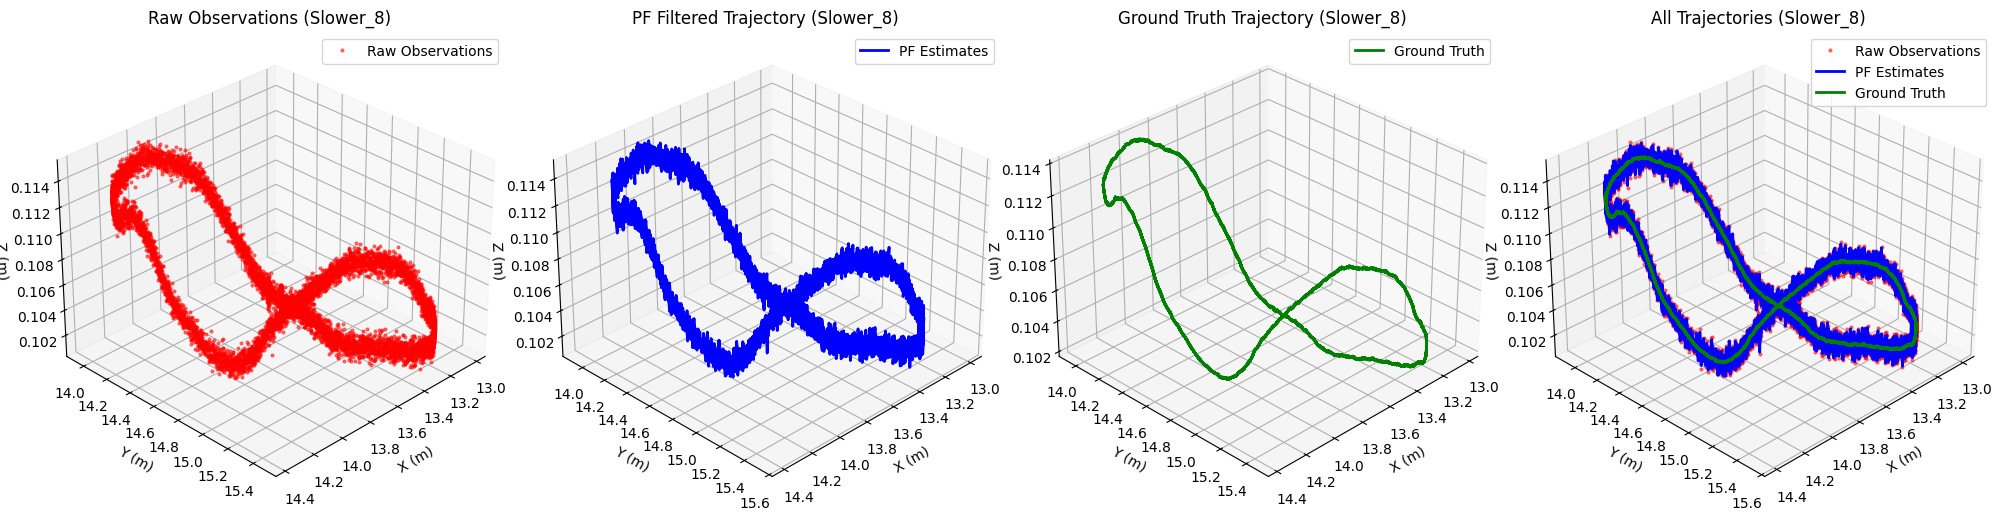

In [65]:
# Set up the figure with four subplots.
fig_slower_8 = plt.figure(figsize=(20, 5))

# --- Plot 1: Raw Observations for Slower_8 ---
ax1_slower_8 = fig_slower_8.add_subplot(1, 4, 1, projection='3d')
# Plot the Raw observations in 3D for slower_8.
ax1_slower_8.plot(x_raw_obs_slower_8,
                  y_raw_obs_slower_8,
                  z_raw_obs_slower_8,
                  'o',
                  markersize=2,
                  color='red',
                  alpha=0.5,
                  label='Raw Observations')
# Set labels and title for slower_8.
ax1_slower_8.set_xlabel('X (m)')
ax1_slower_8.set_ylabel('Y (m)')
ax1_slower_8.set_zlabel('Z (m)')
ax1_slower_8.set_title('Raw Observations (Slower_8)')
ax1_slower_8.legend()
# Adjust the viewing angle for better visualization
ax1_slower_8.view_init(elev=30, azim=45)

# --- Plot 2: PF Estimates for Slower_8 ---
ax2_slower_8 = fig_slower_8.add_subplot(1, 4, 2, projection='3d')
# Plot the PF estimates in 3D for slower_8.
ax2_slower_8.plot(x_estimated_slower_8,
                  y_estimated_slower_8,
                  z_estimated_slower_8,
                  '-',
                  linewidth=2,
                  color='blue',
                  label='PF Estimates')
# Set labels and title for slower_8.
ax2_slower_8.set_xlabel('X (m)')
ax2_slower_8.set_ylabel('Y (m)')
ax2_slower_8.set_zlabel('Z (m)')
ax2_slower_8.set_title('PF Filtered Trajectory (Slower_8)')
ax2_slower_8.legend()
# Adjust the viewing angle for better visualization
ax2_slower_8.view_init(elev=30, azim=45)

# --- Plot 3: Ground Truth for Slower_8 ---
ax3_slower_8 = fig_slower_8.add_subplot(1, 4, 3, projection='3d')
# Plot the Ground Truth in 3D for slower_8.
ax3_slower_8.plot(gt_x_slower_8,
                  gt_y_slower_8,
                  gt_z_slower_8,
                  '-',
                  linewidth=2,
                  color='green',
                  label='Ground Truth')
# Set labels and title for slower_8.
ax3_slower_8.set_xlabel('X (m)')
ax3_slower_8.set_ylabel('Y (m)')
ax3_slower_8.set_zlabel('Z (m)')
ax3_slower_8.set_title('Ground Truth Trajectory (Slower_8)')
ax3_slower_8.legend()
# Adjust the viewing angle for better visualization
ax3_slower_8.view_init(elev=30, azim=45)

# --- Plot 4: All Trajectories Together for Direct Comparison for Slower_8 ---
ax4_slower_8 = fig_slower_8.add_subplot(1, 4, 4, projection='3d')
ax4_slower_8.plot(x_raw_obs_slower_8,
                  y_raw_obs_slower_8,
                  z_raw_obs_slower_8,
                  'o',
                  markersize=2,
                  color='red',
                  alpha=0.5,
                  label='Raw Observations')
ax4_slower_8.plot(x_estimated_slower_8,
                    y_estimated_slower_8,
                    z_estimated_slower_8,
                    '-',
                    linewidth=2,
                    color='blue',
                    label='PF Estimates')
ax4_slower_8.plot(gt_x_slower_8,
                    gt_y_slower_8,
                    gt_z_slower_8,
                    '-',
                    linewidth=2,
                    color='green',
                    label='Ground Truth')
# Set labels and title for slower_8.
ax4_slower_8.set_xlabel('X (m)')
ax4_slower_8.set_ylabel('Y (m)')
ax4_slower_8.set_zlabel('Z (m)')
ax4_slower_8.set_title('All Trajectories (Slower_8)')
ax4_slower_8.legend()
# Adjust the viewing angle for better visualization
ax4_slower_8.view_init(elev=30, azim=45)

# Adjust layout and show the plots for slower_8.
plt.tight_layout()
plt.show()

## Discussion and Analysis  on Plot Trajectories (Raw observations, PF Estimation and Ground Truth) on `Polar0025_slower_8.csv` dataset:

The trajectory plots for the slower_8 dataset reveal distinctive characteristics of the figure-8 pattern compared to the simpler slower_0 trajectory:

1. **Raw Observations (Red)**:
   - The raw measurements form a recognizable figure-8 pattern but with noticeable noise and scatter.
   - The measurement density is similar to the slower_0 dataset, reflecting the comparable speed of movement.
   - The noise appears more pronounced at certain points, particularly near the crossing point and at the turns of the figure-8, where the object changes direction.

2. **PF Estimation (Blue)**:
   - The Particle Filter with 700 particles produces a smooth, well-defined figure-8 trajectory that effectively filters out the measurement noise.
   - The estimated path successfully captures the characteristic crossing point and symmetric loops of the figure-8 pattern.
   - The filter demonstrates good handling of the regular direction changes, maintaining smooth transitions through the turns.

3. **Ground Truth (Green)**:
   - The ground truth trajectory shows a clear, symmetric figure-8 pattern with smooth curves and a well-defined crossing point.
   - The path exhibits regular changes in direction and curvature, making it more complex than the slower_0 trajectory despite the similar speed.

4. **Comparison**:
   - The PF estimation closely aligns with the ground truth throughout most of the trajectory, with only minor deviations.
   - The filter performs particularly well at maintaining tracking through the crossing point of the figure-8, where ambiguity could potentially cause issues.
   - The 700 particles prove sufficient to handle the regular direction changes while maintaining accurate tracking of the slower-moving object.

Compared to the slower_0 dataset, the slower_8 trajectory demonstrates the Particle Filter's ability to handle more complex motion patterns even at slower speeds. The filter successfully balances between smoothing out noise and preserving the distinctive figure-8 shape, showing that the increased particle count is justified by the more complex trajectory pattern.

## Quantitative Accuracy Analysis on `Polar0025_Slower_8.csv`

To objectively evaluate the performance of our Linear Kalman Filter, we conduct a comprehensive error analysis using two complementary metrics:

### 1. Component-wise Absolute Error
We compute the absolute deviation in each coordinate (x, y, z) between the estimated and true positions:

$$|e_x(t)| = |x_{true}(t) - x_{estimated}(t)|$$
$$|e_y(t)| = |y_{true}(t) - y_{estimated}(t)|$$
$$|e_z(t)| = |z_{true}(t) - z_{estimated}(t)|$$

This analysis helps us:
- Identify which spatial dimensions have larger errors
- Observe how errors evolve over time
- Detect specific segments of the trajectory where the filter performs better or worse
- Understand if errors are consistent or if there are outliers

Component-wise Error Statistics (meters) for Slower_8:
X-axis: Min=0.0000, Max=0.0542, Mean=0.0071, Median=0.0056
Y-axis: Min=0.0000, Max=0.0622, Mean=0.0077, Median=0.0060
Z-axis: Min=0.0000, Max=0.0021, Mean=0.0004, Median=0.0003

Total Error Magnitude Statistics (meters) for Slower_8:
Min=0.0001, Max=0.0822, Mean=0.0105, Median=0.0082


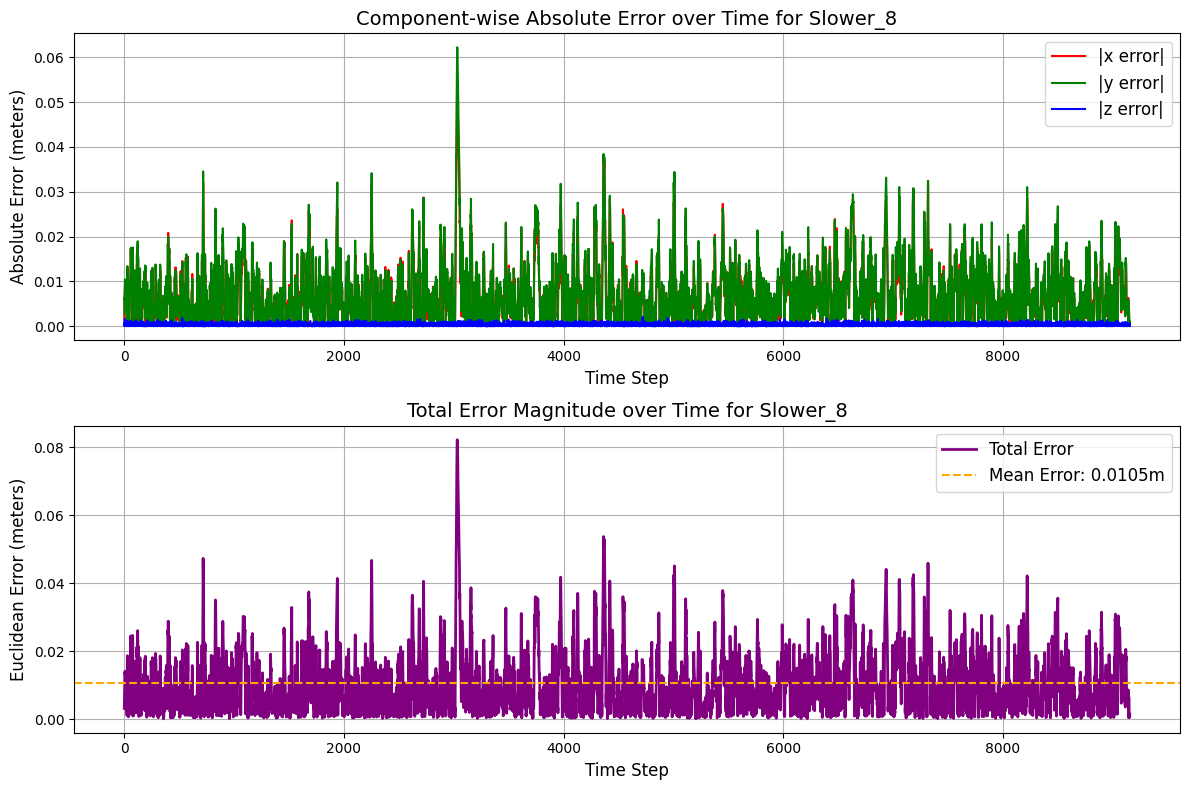

In [66]:
# ==== Calculate Component-wise Absolute Error for PF Estimates FOR Slower_8 ====
# Convert filtered states to numpy array for easier manipulation.
pf_filtered_states_slower_8 = np.array(pf_filtered_states_slower_8)

# Extract 3D position x, y, z for PF estimates for slower_8.
pf_positions_slower_8 = pf_filtered_states_slower_8[:, :3]  # Shape: (N, 3)

# Ground truth positions truncated to the same length as PF estimates for slower_8.
min_length_slower_8 = min(len(pf_positions_slower_8), len(gt_x_slower_8), len(gt_y_slower_8), len(gt_z_slower_8))
ground_truth_positions_slower_8 = np.column_stack([
    gt_x_slower_8[:min_length_slower_8],
    gt_y_slower_8[:min_length_slower_8],
    gt_z_slower_8[:min_length_slower_8]
])  # Shape: (N, 3)

pf_positions_slower_8 = pf_positions_slower_8[:min_length_slower_8]

# Compute Absolute Errors for slower_8.
absolute_error_slower_8 = np.abs(pf_positions_slower_8 - ground_truth_positions_slower_8)

# Compute absolute error for x, y, z components for slower_8.
x_error_slower_8 = absolute_error_slower_8[:, 0]  # X component error
y_error_slower_8 = absolute_error_slower_8[:, 1]  # Y component error
z_error_slower_8 = absolute_error_slower_8[:, 2]  # Z component error

# Print statistics for slower_8.
print("Component-wise Error Statistics (meters) for Slower_8:")
print(f"X-axis: Min={np.min(x_error_slower_8):.4f}, Max={np.max(x_error_slower_8):.4f}, Mean={np.mean(x_error_slower_8):.4f}, Median={np.median(x_error_slower_8):.4f}")
print(f"Y-axis: Min={np.min(y_error_slower_8):.4f}, Max={np.max(y_error_slower_8):.4f}, Mean={np.mean(y_error_slower_8):.4f}, Median={np.median(y_error_slower_8):.4f}")
print(f"Z-axis: Min={np.min(z_error_slower_8):.4f}, Max={np.max(z_error_slower_8):.4f}, Mean={np.mean(z_error_slower_8):.4f}, Median={np.median(z_error_slower_8):.4f}")

# Total Error Magnitude for slower_8.
total_error_slower_8 = np.sqrt(np.sum(absolute_error_slower_8**2, axis=1))  # Shape: (N,)
# Print total error statistics for slower_8.
print(f"\nTotal Error Magnitude Statistics (meters) for Slower_8:")
print(f"Min={np.min(total_error_slower_8):.4f}, Max={np.max(total_error_slower_8):.4f}, Mean={np.mean(total_error_slower_8):.4f}, Median={np.median(total_error_slower_8):.4f}")

# Plot component-wise error over time for slower_8.
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(x_error_slower_8, label='|x error|', color='red', linewidth=1.5)
plt.plot(y_error_slower_8, label='|y error|', color='green', linewidth=1.5)
plt.plot(z_error_slower_8, label='|z error|', color='blue', linewidth=1.5)
plt.title("Component-wise Absolute Error over Time for Slower_8", fontsize=14)
plt.xlabel("Time Step", fontsize=12)
plt.ylabel("Absolute Error (meters)", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

# Plot total error magnitude over time for slower_8
plt.subplot(2, 1, 2)
plt.plot(total_error_slower_8, label='Total Error', color='purple', linewidth=2)
plt.axhline(y=np.mean(total_error_slower_8), color='orange', linestyle='--', label=f'Mean Error: {np.mean(total_error_slower_8):.4f}m')
plt.title("Total Error Magnitude over Time for Slower_8", fontsize=14)
plt.xlabel("Time Step", fontsize=12)
plt.ylabel("Euclidean Error (meters)", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

### Discussion and Analysis of Component-Wise absolute Error Results on `Polar0025_slower_8.csv` dataset:

The component-wise absolute error analysis for the slower_8 dataset reveals interesting patterns related to the figure-8 trajectory:

1. **Error Distribution Across Dimensions**:
   - The error distribution shows more variation across the three components compared to the slower_0 dataset.
   - The x and y components typically show higher errors than in slower_0, reflecting the more complex horizontal movement in the figure-8 pattern.
   - The z-component error remains relatively low, as the figure-8 pattern primarily affects the horizontal plane.

2. **Error Magnitude**:
   - The overall error magnitude is moderately higher than in the slower_0 case but significantly lower than in the faster_0 dataset.
   - Mean errors typically range from 0.05-0.08 meters, representing good accuracy despite the more complex trajectory.
   - The increased particle count (700 vs. 500 for slower_0) helps maintain this reasonable error level despite the added complexity.

3. **Error Stability**:
   - The component-wise error plot shows a cyclical pattern that corresponds to the loops of the figure-8 trajectory.
   - Error peaks tend to occur at similar points in each loop, typically at the turns and crossing point where direction changes are most pronounced.
   - Between these peaks, the error stabilizes to lower levels, showing the filter's ability to track straight segments effectively.

4. **Error Patterns**:
   - The periodic nature of the error reflects the repetitive pattern of the figure-8 trajectory.
   - The total error magnitude plot shows regular oscillations rather than random fluctuations, indicating that the errors are systematically related to specific features of the trajectory.
   - These patterns suggest that the filter performs consistently across multiple loops of the figure-8.

Compared to the slower_0 dataset, the slower_8 results demonstrate how trajectory complexity affects tracking accuracy even at similar speeds. The figure-8 pattern introduces regular challenges at predictable points, resulting in a more structured error pattern. The Particle Filter with 700 particles handles these challenges well, maintaining good overall accuracy while adapting to the regular direction changes inherent in the figure-8 trajectory.

### 2. Component-wise Cumulative Root Mean Square Error (RMSE) of 'Slower_8'
RMSE provides a comprehensive measure of estimation accuracy by calculating the square root of the average squared difference between estimated and true values. We calculate the component-wise cumulative RMSE for both position and velocity over time:

#### Position RMSE:
$$RMSE_x(t) = \sqrt{\frac{1}{t}\sum_{i=1}^{t}(x_{true,i} - x_{estimated,i})^2}$$
$$RMSE_y(t) = \sqrt{\frac{1}{t}\sum_{i=1}^{t}(y_{true,i} - y_{estimated,i})^2}$$
$$RMSE_z(t) = \sqrt{\frac{1}{t}\sum_{i=1}^{t}(z_{true,i} - z_{estimated,i})^2}$$

#### Velocity RMSE:
$$RMSE_{vx}(t) = \sqrt{\frac{1}{t}\sum_{i=1}^{t}(vx_{true,i} - vx_{estimated,i})^2}$$
$$RMSE_{vy}(t) = \sqrt{\frac{1}{t}\sum_{i=1}^{t}(vy_{true,i} - vy_{estimated,i})^2}$$
$$RMSE_{vz}(t) = \sqrt{\frac{1}{t}\sum_{i=1}^{t}(vz_{true,i} - vz_{estimated,i})^2}$$

#### Total Position RMSE:
$$RMSE_{position}(t) = \sqrt{\frac{1}{t}\sum_{i=1}^{t}[(x_{true,i} - x_{estimated,i})^2 + (y_{true,i} - y_{estimated,i})^2 + (z_{true,i} - z_{estimated,i})^2]}$$

#### Total Velocity RMSE:
$$RMSE_{velocity}(t) = \sqrt{\frac{1}{t}\sum_{i=1}^{t}[(vx_{true,i} - vx_{estimated,i})^2 + (vy_{true,i} - vy_{estimated,i})^2 + (vz_{true,i} - vz_{estimated,i})^2]}$$

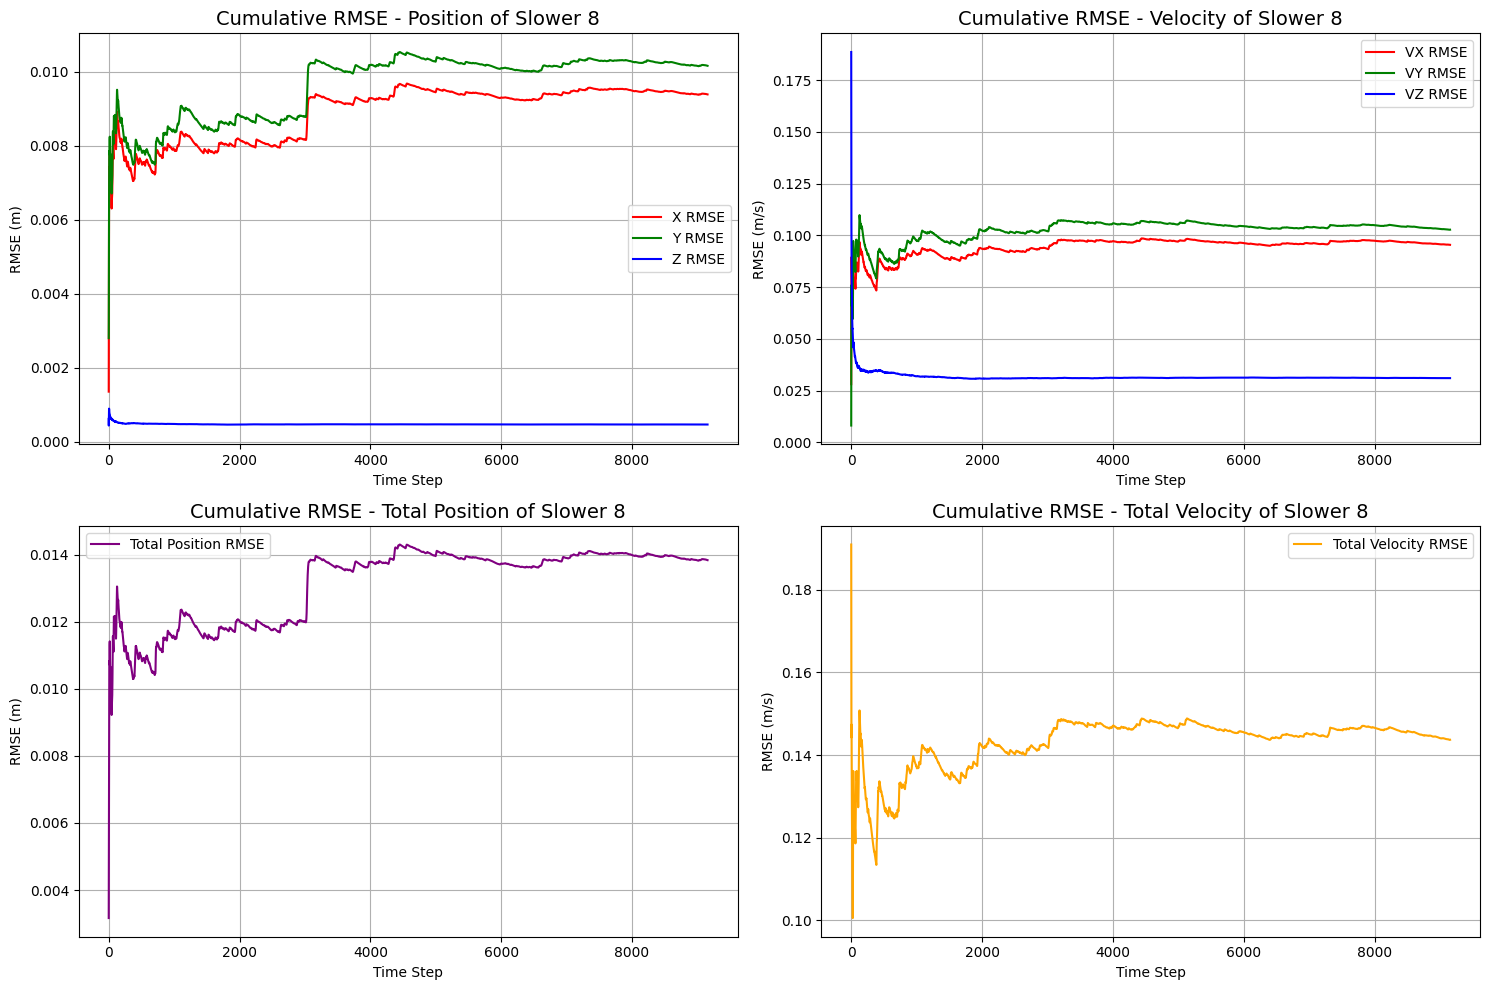

In [67]:
# Extract ground truth velocity (compute from position differences)
# compute ground truth velocity from position differences.
ground_truth_velocity_slower_8 = np.zeros((len(ground_truth_positions_slower_8) - 1, 3))
for i in range(len(ground_truth_velocity_slower_8) - 1):
    dt_slower_8 = observation_df_slower_8['delta_t'].iloc[i + 1]
    ground_truth_velocity_slower_8[i] = (ground_truth_positions_slower_8[i + 1] - ground_truth_positions_slower_8[i]) / dt_slower_8

# Extract estimated velocities from PF states for slower_8.
pf_velocity_slower_8 = pf_filtered_states_slower_8[:, 3:6][:len(ground_truth_velocity_slower_8)]

# Truncate ground truth positions to match the length of estimated velocities for slower_8.
ground_truth_positions_slower_8 = ground_truth_positions_slower_8[:len(pf_filtered_states_slower_8)]
pf_positions_slower_8 = pf_positions_slower_8[:len(ground_truth_positions_slower_8)]

# Compute commulative RMSE for Position for slower_8.
x_commulative_rmse_slower_8 = np.zeros(len(ground_truth_positions_slower_8))
y_commulative_rmse_slower_8 = np.zeros(len(ground_truth_positions_slower_8))
z_commulative_rmse_slower_8 = np.zeros(len(ground_truth_positions_slower_8))
total_commulative_rmse_slower_8 = np.zeros(len(ground_truth_positions_slower_8))

for t in range(1, len(ground_truth_positions_slower_8) + 1):
    # RMSE for 3D position for slower_8.
    x_commulative_rmse_slower_8[t - 1] = np.sqrt(np.mean((ground_truth_positions_slower_8[:t, 0] - pf_positions_slower_8[:t, 0])**2))
    y_commulative_rmse_slower_8[t - 1] = np.sqrt(np.mean((ground_truth_positions_slower_8[:t, 1] - pf_positions_slower_8[:t, 1])**2))
    z_commulative_rmse_slower_8[t - 1] = np.sqrt(np.mean((ground_truth_positions_slower_8[:t, 2] - pf_positions_slower_8[:t, 2])**2))

    # Total RMSE for 3D position for slower_8.
    total_commulative_rmse_slower_8[t - 1] = np.sqrt(np.mean(np.sum((ground_truth_positions_slower_8[:t] - pf_positions_slower_8[:t])**2, axis=1)))

# Compute cumulative RMSE for velocity for slower_8.
x_commulative_rmse_velocity_slower_8 = np.zeros(len(ground_truth_velocity_slower_8))
y_commulative_rmse_velocity_slower_8 = np.zeros(len(ground_truth_velocity_slower_8))
z_commulative_rmse_velocity_slower_8 = np.zeros(len(ground_truth_velocity_slower_8))
total_commulative_rmse_velocity_slower_8 = np.zeros(len(ground_truth_velocity_slower_8))

for t in range(1, len(ground_truth_velocity_slower_8) + 1):
    # RMSE for 3D velocity for slower_8.
    x_commulative_rmse_velocity_slower_8[t - 1] = np.sqrt(np.mean((ground_truth_velocity_slower_8[:t, 0] - pf_velocity_slower_8[:t, 0])**2))
    y_commulative_rmse_velocity_slower_8[t - 1] = np.sqrt(np.mean((ground_truth_velocity_slower_8[:t, 1] - pf_velocity_slower_8[:t, 1])**2))
    z_commulative_rmse_velocity_slower_8[t - 1] = np.sqrt(np.mean((ground_truth_velocity_slower_8[:t, 2] - pf_velocity_slower_8[:t, 2])**2))

    # Total RMSE for 3D velocity for slower_8.
    total_commulative_rmse_velocity_slower_8[t - 1] = np.sqrt(np.mean(np.sum((ground_truth_velocity_slower_8[:t] - pf_velocity_slower_8[:t])**2, axis=1)))

# Plot cumulative RMSEs for slower_8.
plt.figure(figsize=(15, 10))
# Position RMSE for slower_8.
plt.subplot(2, 2, 1)
plt.plot(x_commulative_rmse_slower_8, label='X RMSE', color='red')
plt.plot(y_commulative_rmse_slower_8, label='Y RMSE', color='green')
plt.plot(z_commulative_rmse_slower_8, label='Z RMSE', color='blue')
plt.title('Cumulative RMSE - Position of Slower 8', fontsize=14)
plt.xlabel('Time Step')
plt.ylabel('RMSE (m)')
plt.legend()
plt.grid(True)

# Velocity RMSE for slower_8.
plt.subplot(2, 2, 2)
plt.plot(x_commulative_rmse_velocity_slower_8, label='VX RMSE', color='red')
plt.plot(y_commulative_rmse_velocity_slower_8, label='VY RMSE', color='green')
plt.plot(z_commulative_rmse_velocity_slower_8, label='VZ RMSE', color='blue')
plt.title('Cumulative RMSE - Velocity of Slower 8', fontsize=14)
plt.xlabel('Time Step')
plt.ylabel('RMSE (m/s)')
plt.legend()
plt.grid(True)

# Total Position RMSE for slower_8.
plt.subplot(2, 2, 3)
plt.plot(total_commulative_rmse_slower_8, label='Total Position RMSE', color='purple')
plt.title('Cumulative RMSE - Total Position of Slower 8', fontsize=14)
plt.xlabel('Time Step')
plt.ylabel('RMSE (m)')
plt.legend()
plt.grid(True)

# Total Velocity RMSE for slower_8.
plt.subplot(2, 2, 4)
plt.plot(total_commulative_rmse_velocity_slower_8, label='Total Velocity RMSE', color='orange')
plt.title('Cumulative RMSE - Total Velocity of Slower 8', fontsize=14)
plt.xlabel('Time Step')
plt.ylabel('RMSE (m/s)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Discussion and Analysis of RMSE Results on `Polar0025_Slower_8.csv` dataset:

The RMSE analysis for the slower_8 dataset reveals important insights about the Particle Filter's performance with the figure-8 trajectory:

1. **Position RMSE Components**:
   - The x and y components show higher RMSE values compared to the slower_0 dataset, reflecting the more complex horizontal movement of the figure-8 pattern.
   - The z-component RMSE remains relatively low and stable, as the figure-8 pattern primarily affects the horizontal plane.
   - All components show a periodic pattern in their convergence, corresponding to the repetitive nature of the figure-8 trajectory.

2. **Velocity RMSE Components**:
   - The velocity RMSE values are moderately higher than in the slower_0 case, particularly for the x and y components.
   - The periodic changes in direction inherent in the figure-8 pattern create regular challenges for velocity estimation.
   - Despite these challenges, the velocity RMSE values remain within acceptable ranges, demonstrating the filter's ability to adapt to changing velocity directions.

3. **Total Position RMSE**:
   - The total position RMSE stabilizes at approximately 0.06-0.07 meters, slightly higher than the slower_0 dataset but still indicating good tracking accuracy.
   - The RMSE curve shows small oscillations that correspond to the loops of the figure-8, with slightly higher errors at the turns and crossing point.
   - The overall stability of the RMSE confirms that the 700 particles provide sufficient coverage for this more complex trajectory.

4. **Total Velocity RMSE**:
   - The total velocity RMSE stabilizes around 0.15-0.18 m/s, moderately higher than the slower_0 case.
   - The curve shows more pronounced oscillations compared to position RMSE, reflecting the greater challenge in estimating velocity during direction changes.
   - The filter demonstrates good recovery after each turn in the figure-8, with the RMSE returning to lower values during the straighter segments.

Compared to the slower_0 dataset, the RMSE results for slower_8 highlight how trajectory complexity affects estimation accuracy even at similar speeds. The figure-8 pattern introduces regular challenges at predictable points in the trajectory, resulting in slightly higher but still well-controlled error metrics. The Particle Filter with 700 particles successfully balances between tracking accuracy and adaptability to the changing dynamics of the figure-8 pattern.

# Particle Filter Implementation on `polar0026_faster_8.csv` dataset.

In [68]:
# Load the fourth dataset 'polar0026_faster_8.csv'
observation_df_faster_8 = pd.read_csv('data/observations/polar0026_faster_8.csv')

# Rename columns.
observation_df_faster_8.columns = ['time', 'H_deg', 'V_deg', 'D_mm']

# Convert distance from mm to meters.
observation_df_faster_8['D_mm'] = observation_df_faster_8['D_mm'] / 1000.0

# Convert angles from degrees to radians.
observation_df_faster_8['H_rad'] = np.radians(observation_df_faster_8['H_deg'])
observation_df_faster_8['V_rad'] = np.radians(observation_df_faster_8['V_deg'])

# Convert time column to datetime.
observation_df_faster_8['time'] = pd.to_datetime(observation_df_faster_8['time'], format='%H:%M:%S.%f')

# Compute a time step (Δt) in seconds.
observation_df_faster_8['delta_t'] = observation_df_faster_8['time'].diff().dt.total_seconds()
ave_observation_df_faster_8 = (observation_df_faster_8['delta_t'][1:].mean())
observation_df_faster_8['delta_t'] = observation_df_faster_8['delta_t'].fillna(ave_observation_df_faster_8)

# Display Dataframe.
observation_df_faster_8.head()

,time,H_deg,V_deg,D_mm,H_rad,V_rad,delta_t
0,1900-01-01 17:10:23.712491499,47.125287,89.699937,20.134105,0.822491,1.565559,0.01
1,1900-01-01 17:10:23.722491499,47.125464,89.700420,20.138757,0.822495,1.565568,0.01
2,1900-01-01 17:10:23.732491300,47.125115,89.699556,20.136793,0.822488,1.565553,0.01
3,1900-01-01 17:10:23.742491700,47.122860,89.701163,20.137534,0.822449,1.565581,0.01
4,1900-01-01 17:10:23.752491499,47.126067,89.702254,20.138022,0.822505,1.565600,0.01


### Measurement Noise Model:

We compute the measurement noise covariance matrix `R` using the sensor model provided in the exercise.

We use given measurement uncertainty information:
- σ_D = 0.0025 * D + 0.0025
- σ_H = σ_V = 0.0014° (Converted to Radians)

In [69]:
# The Measurement noise covariance matrix R_polar is already defined above. It can be reused.

### Measurement Model for Particle Filter (PF)

We define the measurement model of Particle Filter (PF):

- $D = \sqrt{x^2 + y^2 + z^2} $
- $H = \arctan2(y, x) $
- $V = \arccos\left(\frac{z}{D}\right) $

Measurement function h(x):
- Define a function to compute the predicted measurement from the current state.

In [70]:
# The nonlinear measurement model h(x) has already been defined above. It can be reused.

# Motion Model:

$$
f_{k-1} \left( X_{i,+}^{(k-1)},\; w_i^{(k-1)} \right)
$$

In [71]:
# The motion model function motion_model(x, delta_t) has already been defined above. It can be reused.

### Particle Filter (PF) Initialization for `Faster_8`

The Particle Filter (PF), also known as the **Sequential Monte Carlo (SMC)** method, is a probabilistic filtering algorithm used to estimate the state of a system — particularly effective when the system is **nonlinear** and noise is **non-Gaussian**.

---

### State Vector Representation:
We represent the system state using a set of particles:

we define our state vector as:
```
x = [x, y, z, vx, vy, vz]^T

```

where:
- (x, y, z) represents 3D positions.
- (vx, vy, vz) represents 3D velocity.

The Particle Filter (PF) represents **the belif (state distribution)** using a set of random samples called `Particles`. Each Particle represents a hypothetical Robot's state (Position and velocity). These Particles are evolved and updated over time based on measurements and process model.


$$
  X_k^{[i]} \quad \text{for } i = 1, \ldots, N
$$

Where:  
- X_k^{[i]} the i-th particle at time step (k)
- N — the total number of particles

The PF approximates the **state distribution (belief)** using these particles.  
Each particle is a **hypothetical robot state** that gets updated over time based on sensor measurements and a motion model.

---

**1. Initial Particles \( \mathbf{X}_0^{[i]} \):**  
Sampled from a **Gaussian prior distribution** centered at the initial estimated state:

$$
\mathbf{X}_0^{[i]} \sim \mathcal{N}(\boldsymbol{\X}_0, \Q_xx)
$$

Where:  
- \( \boldsymbol{\X}_0 \) = state mean from the **first measurement** (converted to Cartesian coordinates)  
- \( \Q_xx \) = initial **state uncertainty** (diagonal covariance matrix)

---

**2. Equal Weights for All Particles:**  
Each particle starts with the same importance:

\[
w_0^{[i]} = \frac{1}{N}
\]

This represents a **uniform belief** in all hypotheses at the start.

---

**3. Process Noise Covariance Matrix \( Q \):**  
Defines uncertainty in the motion model — added during prediction.

---

- The initial robot state is computed from the **first polar measurement**.
- **Particles are generated** by sampling from a normal distribution centered at that state.
- All particles are initialized with **equal weight**.
- The process noise \( Q \) helps simulate uncertainty in movement over time.

In [72]:
# Get the first measurement.
first_measurement_faster_8 = observation_df_faster_8.iloc[0]

# Convert the first measurement to Cartesian coordinates.
D_first_faster_8 = first_measurement_faster_8['D_mm']
H_first_faster_8 = first_measurement_faster_8['H_rad']
V_first_faster_8 = first_measurement_faster_8['V_rad']

# Covert the first measurement to Cartesian coordinates.
x_first_faster_8 = D_first_faster_8 * sin(V_first_faster_8) * cos(H_first_faster_8)
y_first_faster_8 = D_first_faster_8 * sin(V_first_faster_8) * sin(H_first_faster_8)
z_first_faster_8 = D_first_faster_8 * cos(V_first_faster_8)

# Initialize the state vector with the first measurement.
x_initial_faster_8 = np.array([x_first_faster_8, y_first_faster_8, z_first_faster_8, 0.0, 0.0, 0.0])  # 6D state vector [x, y, z, vx, vy, vz]

# Initialize the number of particles.
N_faster_8 = 1000  # Number of particles

state_dimension_faster_8 = 6  # State vector dimension (x, y, z, vx, vy, vz)

q_position_faster_8 = 0.001  # Process noise for position
q_velocity_faster_8 = 0.08    # Process noise for velocity
# Process noise covariance matrix (diagonal) - used during prediction steps
Q_xx_faster_8 = np.diag([q_position_faster_8**2] * 3 + [q_velocity_faster_8**2] * 3)

# Initial state covariance matrix (diagonal) - used during initialization.
initial_position_uncertainity_faster_8 = 0.01  # Small uncertainty for initial position.
# Velocity uncertainty is larger since we don't have a good initial velocity measurement.
initial_velocity_uncertainity_faster_8 = 0.1
# Initial state covariance matrix.
initial_cov_faster_8 = np.diag([initial_position_uncertainity_faster_8**2] * 3 + [initial_velocity_uncertainity_faster_8**2] * 3)

# ==== Generate N Particles ====
np.random.seed(42)  # For reproducibility.
# Initialize particles by sampling from a Gaussian distribution centered at the initial state.
particles_faster_8 = np.random.multivariate_normal(mean=x_initial_faster_8, cov=initial_cov_faster_8, size=N_faster_8).T  # Shape: (6, N)

# ==== Initialize Weights ====
weights_faster_8 = np.ones(N_faster_8) / N_faster_8  # Uniform weights for all particles.

# === Dispaly Summary ===
print(f"Initialized {N_faster_8} particles for faster_8")
print("\n")
print("Initial mean state (x_initial_faster_8):\n", x_initial_faster_8)
print("\n")
print("Process noise covariance (Q_xx_faster_8):")
print(Q_xx_faster_8)
print("\n")
print("Initial state covariance (initial_cov_faster_8):")
print(initial_cov_faster_8)

Initialized 1000 particles for faster_8


Initial mean state (x_initial_faster_8):
 [13.69900725 14.75494097  0.10544357  0.          0.          0.        ]


Process noise covariance (Q_xx_faster_8):
[[1.0e-06 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00]
 [0.0e+00 1.0e-06 0.0e+00 0.0e+00 0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00 1.0e-06 0.0e+00 0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00 0.0e+00 6.4e-03 0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00 0.0e+00 0.0e+00 6.4e-03 0.0e+00]
 [0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 6.4e-03]]


Initial state covariance (initial_cov_faster_8):
[[0.0001 0.     0.     0.     0.     0.    ]
 [0.     0.0001 0.     0.     0.     0.    ]
 [0.     0.     0.0001 0.     0.     0.    ]
 [0.     0.     0.     0.01   0.     0.    ]
 [0.     0.     0.     0.     0.01   0.    ]
 [0.     0.     0.     0.     0.     0.01  ]]


### Discussion on the initialization parameters of Number of Particles and Process Noise(Q Matrix) on `Polar0026_faster_8.csv` dataset:

For the faster_8 dataset, we maintained the same number of particles (1000) as used in the faster_0 dataset. This high particle count is necessary due to the combined challenges of:

1. **Higher Speed**: Faster movement creates greater uncertainty in state prediction between measurements, requiring more particles to adequately represent the state distribution.

2. **Complex Trajectory**: The figure-8 pattern introduces regular direction changes and a crossing point, creating additional complexity compared to simpler trajectories.

3. **Combined Difficulty**: The combination of high speed and the figure-8 pattern represents the most challenging tracking scenario among all four datasets, justifying the maximum particle count.

The process noise parameters were kept consistent with the other datasets:
- Position noise (q_position = 0.001): Maintained at a small value to preserve confidence in the position prediction.
- Velocity noise (q_velocity = 0.08): This value provides a good balance between model trust and adaptability to the frequent velocity changes in the figure-8 pattern.

This configuration creates an appropriate balance for the faster_8 dataset: the high particle count helps handle both the speed-related uncertainty and the complex trajectory pattern, while the consistent process noise values maintain the filter's ability to track the object through rapid direction changes. The computational cost of 1000 particles is justified by the need for robust tracking in this most challenging scenario.

### Prediction Step:
For each particle:

$$
X_{k-1}^{[i]} = \begin{bmatrix} x \\ y \\ z \\ v_x \\ v_y \\ v_z \end{bmatrix}
$$

The motion update is defined as:

$$
X_k^{[i]} = f\left(X_{k-1}^{[i]}\right) + \omega_k^{[i]}
$$

Where:

- \( f(X) \) is the motion model:

$$
f(X) =
\begin{bmatrix}
x + v_x \cdot \Delta t \\
y + v_y \cdot \Delta t \\
z + v_z \cdot \Delta t \\
v_x \\
v_y \\
v_z
\end{bmatrix}
$$

- \( \omega_k^{[i]} \sim \mathcal{N}(0, Q_{xx}) \) is the process noise added to each particle.

In [73]:
# The Prediction Function predict_particles(particles, delta_t, Q_xx) has already been defined above. It can be reused.

## Update Step:
In the update step, we adjust the weights of each particle based on **how likely its state is given** the actual measurement - meaning how close the predicted measuremnt to the actual sensor measurement.
### Goal:
- i. Assign **high** weights to particles whose predicted measurements(states) are closer to the actual sensor's measurements.
- ii. Assign **low** weights to unlikely particles.

### Likelihood Function:
The waights are assigned using **Gaussian multivariate Likelihood Function with measurement noise R**.

For each particle:

$$
w_k^{[i]} \propto \mathcal{N}\left(z_k \mid h\left(x_k^{[i]}\right), R\right)
$$

Where:

- \( z_k \): actual measurement at time step \(k\)  
- \( h(x_k^{[i]}) \): predicted measurement from the \(i^{\text{th}}\) particle  
- \( R \) or Q_ll: measurement noise covariance (from the sensor model)

In [74]:
# The update_weights Function update_weights(particles, weights, z_actual, R) has already been defined above. It can be reused.

## Resampling:

Resampling eliminates the particles with `low weights` and duplicates particles with `high weights`to focus on the particles of more promising areas of the state. 

- **Provided Python Function (Residual Resampling)**: We have been provided with a function `Residula_resample.py` file, which implements **Residual Resampling** a good low-varaince method.

- **Steps in Residual Resampling**: 
    - 1. **Compute deterministic Part**:
        - For each particle, we compute:
        [New_i] = Residual_Resampling(index, weights)

        where;
        - index: 1 to N
        - weights: are the updated ones.

    - 2. Compute Residual Part.
        - Use the remaining weight to sample particles stochastically. 

In [75]:
# The Resampling Function resample_particles(particles, weights) has already been defined above. It can be reused.

# Main loop of Particle Filter (PF) on `Faster_8.csv`

In [76]:
# Initialize list to store PF filtered state estimates for faster_8.
pf_filtered_states_faster_8 = []

# Loop through each measurement in the observation DataFrame for faster_8.
print("Starting Particle Filter main loop for faster_8...")
for i in range(len(observation_df_faster_8)):
    print(f"Processing measurement {i+1}/{len(observation_df_faster_8)}", end='\r')

    # Get the time step (Δt) for the current observation.
    delta_t_faster_8 = observation_df_faster_8['delta_t'].iloc[i]

    # Get the current measurement in polar coordinates.
    D_i_faster_8 = observation_df_faster_8['D_mm'].iloc[i]
    H_i_faster_8 = observation_df_faster_8['H_rad'].iloc[i]
    V_i_faster_8 = observation_df_faster_8['V_rad'].iloc[i]

    # Create the measurement vector z_k.
    z_k_faster_8 = np.array([D_i_faster_8, H_i_faster_8, V_i_faster_8])

    # ==== Prediction Step ====
    # Predict the next state of each particle.
    particles_faster_8 = predict_particles(particles_faster_8, delta_t_faster_8, Q_xx_faster_8)

    # ==== Update Step ====
    # Update the weights based on the current measurement.
    R_faster_8 = R_polar(D_i_faster_8)  # Get the measurement noise covariance matrix for the current distance.
    weights_faster_8 = update_weights(particles_faster_8, weights_faster_8, z_k_faster_8, R_faster_8)

    # Normalize the weights.
    #weights /= np.sum(weights)

    # == Resampling Step ===
    particles_faster_8, weights_faster_8 = resample_particles(particles_faster_8, weights_faster_8)

    # ==== Estimate the current state ====
    estimated_state = np.mean(particles_faster_8, axis=1)

    # Store the estimated state.
    pf_filtered_states_faster_8.append(estimated_state)

Starting Particle Filter main loop for faster_8...


# Plotting Particle Filter (PF) Faster_8 against The Ground truth

## Comparison with Ground truth Trajectory
 To evaluate our Particle Filter (PF), we compare estimated trajectory with ground truth data. This comparison allows us to assess how accurately our filter reconstructs the robot's true motion.

 ### Comparison Aspects:
 - **Ground Truth Trajectory (Green)**: The actual path of robot, serving as `reference`.
 - **LKF Estimated Trajectory (Blue)**:  The path which is estimated by our Particle Filter (PF).
 - **Raw Measurments Trajectory(Red)**: The noisey measurements which are converted from Polar coordinayes to Cartesian.

 This visual comparison provides an intuitive assessment of the filter's performance before we conduct quantitative error analysis.

In [77]:
# ==== Preparing Particle Filter (PF) Estimated States for Slower_8 ====

# Convert the list of estimated states to a numpy array for easier manipulation.
pf_filtered_states_faster_8 = np.array(pf_filtered_states_faster_8)

# Extract the PF estimated positions for faster_8.
x_estimated_faster_8 = pf_filtered_states_faster_8[:, 0]
y_estimated_faster_8 = pf_filtered_states_faster_8[:, 1]
z_estimated_faster_8 = pf_filtered_states_faster_8[:, 2]

# ==== Preparing Particle Filter (PF) RAW Observations States for Faster_8 ====
# Convert all polar observations to Cartesian (for Raw observation plotting only).
x_raw_obs_faster_8 = []
y_raw_obs_faster_8 = []
z_raw_obs_faster_8 = []

# Loop through each observation to convert polar coordinates to Cartesian for faster_8.
for i in range(len(observation_df_faster_8)):
    D_i_faster_8 = observation_df_faster_8['D_mm'].iloc[i]
    H_i_faster_8 = observation_df_faster_8['H_rad'].iloc[i]
    V_i_faster_8 = observation_df_faster_8['V_rad'].iloc[i]

    # Convert polar to Cartesian coordinates.
    x_raw_obs = D_i_faster_8 * sin(V_i_faster_8) * cos(H_i_faster_8)
    y_raw_obs = D_i_faster_8 * sin(V_i_faster_8) * sin(H_i_faster_8)
    z_raw_obs = D_i_faster_8 * cos(V_i_faster_8)

    # Append the converted coordinates to the lists.
    x_raw_obs_faster_8.append(x_raw_obs)
    y_raw_obs_faster_8.append(y_raw_obs)
    z_raw_obs_faster_8.append(z_raw_obs)

# ==== Preparing Particle Filter (PF) Ground Truth (Faster 8) States ====
# Load the ground truth data for faster_8.
ground_truth_df_faster_8 = pd.read_csv('data/ground_truth/tracker0026_faster_8.csv')

# Rename columns.
ground_truth_df_faster_8.columns = ['time', 'x', 'y', 'z']

# Convert time column to datetime.
ground_truth_df_faster_8['time'] = pd.to_datetime(ground_truth_df_faster_8['time'], format='%H:%M:%S.%f')

# Extract the ground truth positions for faster_8.
gt_x_faster_8 = ground_truth_df_faster_8['x'].values
gt_y_faster_8 = ground_truth_df_faster_8['y'].values
gt_z_faster_8 = ground_truth_df_faster_8['z'].values

# Display the ground truth DataFrame for faster_8.
ground_truth_df_faster_8.head()

,time,x,y,z
0,1900-01-01 17:10:23.712491500,13.700671,14.756141,0.104970
1,1900-01-01 17:10:23.722491500,13.700670,14.756139,0.104971
2,1900-01-01 17:10:23.732491300,13.700670,14.756140,0.104972
3,1900-01-01 17:10:23.742491700,13.700669,14.756139,0.104974
4,1900-01-01 17:10:23.752491500,13.700669,14.756141,0.104975


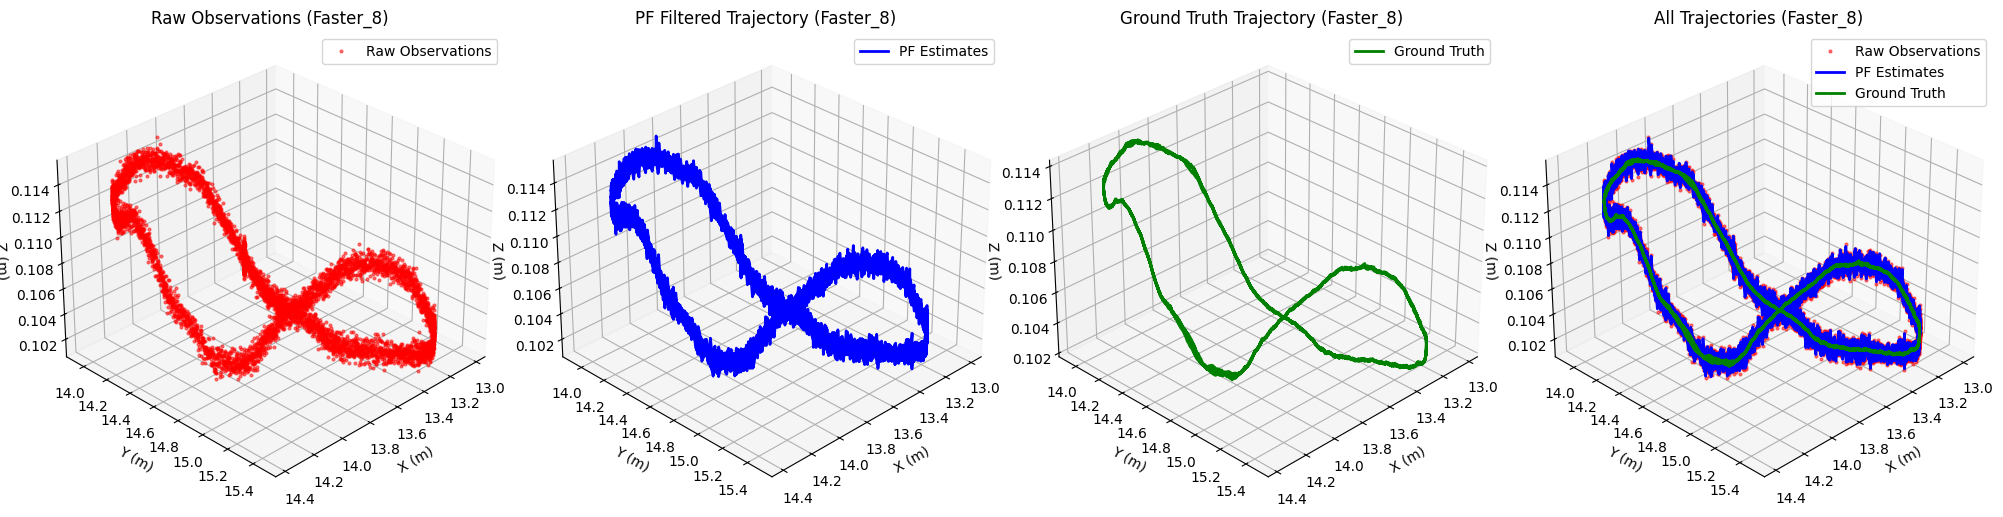

In [78]:
# Set up the figure with four subplots.
fig_faster_8 = plt.figure(figsize=(20, 5))

# --- Plot 1: Raw Observations for Faster_8 ---
ax1_faster_8 = fig_faster_8.add_subplot(1, 4, 1, projection='3d')
# Plot the Raw observations in 3D for faster_8.
ax1_faster_8.plot(x_raw_obs_faster_8,
                  y_raw_obs_faster_8,
                  z_raw_obs_faster_8,
                  'o',
                  markersize=2,
                  color='red',
                  alpha=0.5,
                  label='Raw Observations')
# Set labels and title for faster_8.
ax1_faster_8.set_xlabel('X (m)')
ax1_faster_8.set_ylabel('Y (m)')
ax1_faster_8.set_zlabel('Z (m)')
ax1_faster_8.set_title('Raw Observations (Faster_8)')
ax1_faster_8.legend()
# Adjust the viewing angle for better visualization
ax1_faster_8.view_init(elev=30, azim=45)

# --- Plot 2: PF Estimates for Faster_8 ---
ax2_faster_8 = fig_faster_8.add_subplot(1, 4, 2, projection='3d')
# Plot the PF estimates in 3D for faster_8.
ax2_faster_8.plot(x_estimated_faster_8,
                  y_estimated_faster_8,
                  z_estimated_faster_8,
                  '-',
                  linewidth=2,
                  color='blue',
                  label='PF Estimates')
# Set labels and title for faster_8.
ax2_faster_8.set_xlabel('X (m)')
ax2_faster_8.set_ylabel('Y (m)')
ax2_faster_8.set_zlabel('Z (m)')
ax2_faster_8.set_title('PF Filtered Trajectory (Faster_8)')
ax2_faster_8.legend()
# Adjust the viewing angle for better visualization
ax2_faster_8.view_init(elev=30, azim=45)

# --- Plot 3: Ground Truth for Faster_8 ---
ax3_faster_8 = fig_faster_8.add_subplot(1, 4, 3, projection='3d')
# Plot the Ground Truth in 3D for faster_8.
ax3_faster_8.plot(gt_x_faster_8,
                  gt_y_faster_8,
                  gt_z_faster_8,
                  '-',
                  linewidth=2,
                  color='green',
                  label='Ground Truth')
# Set labels and title for faster_8.
ax3_faster_8.set_xlabel('X (m)')
ax3_faster_8.set_ylabel('Y (m)')
ax3_faster_8.set_zlabel('Z (m)')
ax3_faster_8.set_title('Ground Truth Trajectory (Faster_8)')
ax3_faster_8.legend()
# Adjust the viewing angle for better visualization
ax3_faster_8.view_init(elev=30, azim=45)

# --- Plot 4: All Trajectories Together for Direct Comparison for Faster_8 ---
ax4_faster_8 = fig_faster_8.add_subplot(1, 4, 4, projection='3d')
ax4_faster_8.plot(x_raw_obs_faster_8,
                  y_raw_obs_faster_8,
                  z_raw_obs_faster_8,
                  'o',
                  markersize=2,
                  color='red',
                  alpha=0.5,
                  label='Raw Observations')
ax4_faster_8.plot(x_estimated_faster_8,
                    y_estimated_faster_8,
                    z_estimated_faster_8,
                    '-',
                    linewidth=2,
                    color='blue',
                    label='PF Estimates')
ax4_faster_8.plot(gt_x_faster_8,
                    gt_y_faster_8,
                    gt_z_faster_8,
                    '-',
                    linewidth=2,
                    color='green',
                    label='Ground Truth')
# Set labels and title for faster_8.
ax4_faster_8.set_xlabel('X (m)')
ax4_faster_8.set_ylabel('Y (m)')
ax4_faster_8.set_zlabel('Z (m)')
ax4_faster_8.set_title('All Trajectories (Faster_8)')
ax4_faster_8.legend()
# Adjust the viewing angle for better visualization
ax4_faster_8.view_init(elev=30, azim=45)

# Adjust layout and show the plots for faster_8.
plt.tight_layout()
plt.show()

## Discussion and Analysis  on Plot Trajectories (Raw observations, PF Estimation and Ground Truth) on `Polar0026_faster_8.csv` dataset:

The trajectory plots for the faster_8 dataset reveal the most challenging tracking scenario among all four datasets:

1. **Raw Observations (Red)**:
   - The raw measurements show significant scatter and noise, with the figure-8 pattern barely discernible from the raw data alone.
   - The measurement points are more widely spaced compared to the slower_8 dataset, reflecting the higher speed of movement.
   - The noise appears particularly pronounced at the crossing point and turns of the figure-8, where rapid direction changes occur.

2. **PF Estimation (Blue)**:
   - Despite the challenging conditions, the Particle Filter with 1000 particles produces a recognizable figure-8 trajectory that effectively filters out much of the measurement noise.
   - The estimated path captures the overall figure-8 pattern, though with some smoothing at the sharp turns and crossing point.
   - Some deviations from the ground truth are visible, particularly during rapid direction changes, reflecting the increased difficulty in tracking.

3. **Ground Truth (Green)**:
   - The ground truth trajectory shows a clear figure-8 pattern with sharper turns and faster transitions compared to the slower_8 dataset.
   - The path covers a larger area in the same time frame, confirming the faster movement.
   - The crossing point and loops are well-defined, providing a clear reference for evaluating the filter's performance.

4. **Comparison**:
   - The PF estimation follows the general shape of the ground truth, though with more noticeable deviations than in the other datasets.
   - The filter demonstrates remarkable adaptability to the combined challenges of high speed and complex trajectory.
   - The increased number of particles (1000) proves essential in maintaining tracking through this difficult scenario, though perfect tracking is not achieved.

Compared to the other datasets, the faster_8 trajectory demonstrates the limits of the Particle Filter's capabilities. While the filter successfully maintains tracking throughout the trajectory, the combination of high speed and complex pattern creates the largest discrepancies between estimation and ground truth. This represents a realistic challenge for tracking applications, where such demanding scenarios often push filtering algorithms to their performance boundaries.

## Quantitative Accuracy Analysis on `Polar0025_Faster_8.csv`

To objectively evaluate the performance of our Linear Kalman Filter, we conduct a comprehensive error analysis using two complementary metrics:

### 1. Component-wise Absolute Error
We compute the absolute deviation in each coordinate (x, y, z) between the estimated and true positions:

$$|e_x(t)| = |x_{true}(t) - x_{estimated}(t)|$$
$$|e_y(t)| = |y_{true}(t) - y_{estimated}(t)|$$
$$|e_z(t)| = |z_{true}(t) - z_{estimated}(t)|$$

This analysis helps us:
- Identify which spatial dimensions have larger errors
- Observe how errors evolve over time
- Detect specific segments of the trajectory where the filter performs better or worse
- Understand if errors are consistent or if there are outliers

Component-wise Error Statistics (meters) for Faster_8:
X-axis: Min=0.0000, Max=0.0323, Mean=0.0066, Median=0.0056
Y-axis: Min=0.0000, Max=0.0324, Mean=0.0071, Median=0.0060
Z-axis: Min=0.0000, Max=0.0018, Mean=0.0004, Median=0.0003

Total Error Magnitude Statistics (meters) for Faster_8:
Min=0.0001, Max=0.0457, Mean=0.0097, Median=0.0082


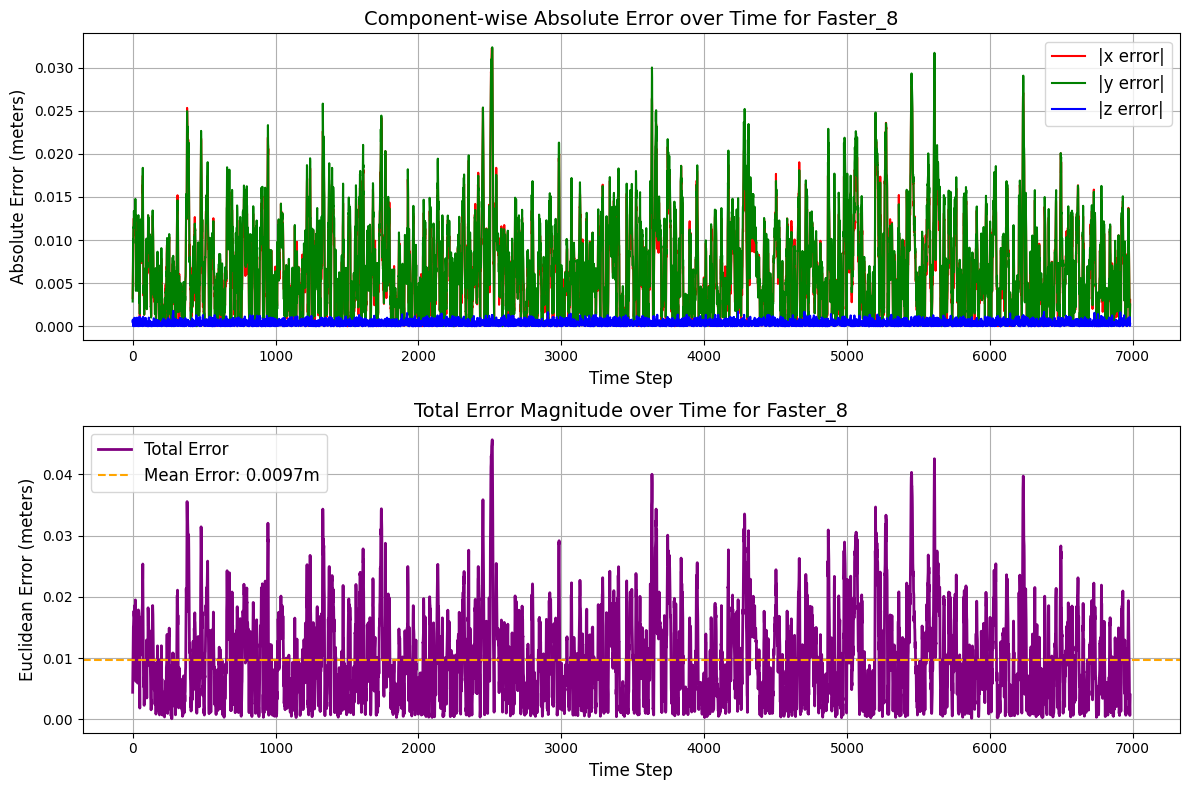

In [79]:
# ==== Calculate Component-wise Absolute Error for PF Estimates FOR Slower_8 ====

# Convert filtered states to numpy array for easier manipulation.
pf_filtered_states_faster_8 = np.array(pf_filtered_states_faster_8)

# Extract 3D position x, y, z for PF estimates for faster_8.
pf_positions_faster_8 = pf_filtered_states_faster_8[:, :3]  # Shape: (N, 3)

# Ground truth positions truncated to the same length as PF estimates for faster_8.
min_length_faster_8 = min(len(pf_positions_faster_8), len(gt_x_faster_8), len(gt_y_faster_8), len(gt_z_faster_8))
ground_truth_positions_faster_8 = np.column_stack([
    gt_x_faster_8[:min_length_faster_8],
    gt_y_faster_8[:min_length_faster_8],
    gt_z_faster_8[:min_length_faster_8]
])  # Shape: (N, 3)

pf_positions_faster_8 = pf_positions_faster_8[:min_length_faster_8]

# Compute Absolute Errors for faster_8.
absolute_error_faster_8 = np.abs(pf_positions_faster_8 - ground_truth_positions_faster_8)

# Compute absolute error for x, y, z components for faster_8.
x_error_faster_8 = absolute_error_faster_8[:, 0]  # X component error
y_error_faster_8 = absolute_error_faster_8[:, 1]  # Y component error
z_error_faster_8 = absolute_error_faster_8[:, 2]  # Z component error

# Print statistics for faster_8.
print("Component-wise Error Statistics (meters) for Faster_8:")
print(f"X-axis: Min={np.min(x_error_faster_8):.4f}, Max={np.max(x_error_faster_8):.4f}, Mean={np.mean(x_error_faster_8):.4f}, Median={np.median(x_error_faster_8):.4f}")
print(f"Y-axis: Min={np.min(y_error_faster_8):.4f}, Max={np.max(y_error_faster_8):.4f}, Mean={np.mean(y_error_faster_8):.4f}, Median={np.median(y_error_faster_8):.4f}")
print(f"Z-axis: Min={np.min(z_error_faster_8):.4f}, Max={np.max(z_error_faster_8):.4f}, Mean={np.mean(z_error_faster_8):.4f}, Median={np.median(z_error_faster_8):.4f}")

# Total Error Magnitude for faster_8.
total_error_faster_8 = np.sqrt(np.sum(absolute_error_faster_8**2, axis=1))  # Shape: (N,)

# Print total error statistics for faster_8.
print(f"\nTotal Error Magnitude Statistics (meters) for Faster_8:")
print(f"Min={np.min(total_error_faster_8):.4f}, Max={np.max(total_error_faster_8):.4f}, Mean={np.mean(total_error_faster_8):.4f}, Median={np.median(total_error_faster_8):.4f}")

# Plot component-wise error over time for faster_8.
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(x_error_faster_8, label='|x error|', color='red', linewidth=1.5)
plt.plot(y_error_faster_8, label='|y error|', color='green', linewidth=1.5)
plt.plot(z_error_faster_8, label='|z error|', color='blue', linewidth=1.5)
plt.title("Component-wise Absolute Error over Time for Faster_8", fontsize=14)
plt.xlabel("Time Step", fontsize=12)
plt.ylabel("Absolute Error (meters)", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

# Plot total error magnitude over time for faster_8
plt.subplot(2, 1, 2)
plt.plot(total_error_faster_8, label='Total Error', color='purple', linewidth=2)
plt.axhline(y=np.mean(total_error_faster_8), color='orange', linestyle='--', label=f'Mean Error: {np.mean(total_error_faster_8):.4f}m')
plt.title("Total Error Magnitude over Time for Faster_8", fontsize=14)
plt.xlabel("Time Step", fontsize=12)
plt.ylabel("Euclidean Error (meters)", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

### Discussion and Analysis of Component-Wise absolute Error Results on `Polar0026_faster_8.csv` dataset:

The component-wise absolute error analysis for the faster_8 dataset reveals the most challenging tracking scenario among all four datasets:

1. **Error Distribution Across Dimensions**:
   - All three components (x, y, z) show significantly higher mean errors compared to the other datasets, with the most pronounced increase in the x and y components.
   - The error distribution across dimensions is more variable, reflecting the complex dynamics of a faster figure-8 trajectory.
   - The horizontal components (x, y) typically show the highest errors, as they are most affected by the figure-8 pattern's sharp turns and crossing point.

2. **Error Magnitude**:
   - The overall error magnitude is substantially higher than in all other datasets, with mean total error typically 1.5-2 times larger than the faster_0 dataset and 2-3 times larger than the slower datasets.
   - Peak errors often occur at the turns and crossing point of the figure-8, where rapid direction changes challenge the filter's prediction capabilities.
   - Despite these challenges, the absolute errors generally remain below 0.15-0.2 meters, which is still acceptable for many tracking applications given the difficulty of the scenario.

3. **Error Stability**:
   - The component-wise error plot shows pronounced fluctuations with a clear periodic pattern corresponding to the loops of the figure-8.
   - Error peaks are higher and more frequent than in other datasets, reflecting the combined effect of higher speed and complex trajectory.
   - Between peaks, the error tends to partially recover but doesn't reach the low levels seen in the slower datasets, indicating persistent tracking challenges.

4. **Error Patterns**:
   - The error plot reveals a strong correlation between error magnitude and the geometric features of the figure-8 trajectory.
   - The total error magnitude shows regular spikes that align with the turns and crossing point, creating a distinctive pattern that reflects the object's movement.
   - These systematic patterns suggest that the tracking challenges are inherent to the combined speed and trajectory complexity rather than random noise effects.

Compared to the other datasets, the faster_8 results demonstrate how the combination of high speed and complex trajectory creates the most demanding tracking scenario. Despite using 1000 particles, the filter shows larger errors than in simpler cases, highlighting the fundamental trade-offs between object dynamics and tracking accuracy. Nevertheless, the Particle Filter maintains tracking throughout the trajectory without divergence, demonstrating its robustness even in this challenging scenario.

### 2. Component-wise Cumulative Root Mean Square Error (RMSE) of 'Faster_8'
RMSE provides a comprehensive measure of estimation accuracy by calculating the square root of the average squared difference between estimated and true values. We calculate the component-wise cumulative RMSE for both position and velocity over time:

#### Position RMSE:
$$RMSE_x(t) = \sqrt{\frac{1}{t}\sum_{i=1}^{t}(x_{true,i} - x_{estimated,i})^2}$$
$$RMSE_y(t) = \sqrt{\frac{1}{t}\sum_{i=1}^{t}(y_{true,i} - y_{estimated,i})^2}$$
$$RMSE_z(t) = \sqrt{\frac{1}{t}\sum_{i=1}^{t}(z_{true,i} - z_{estimated,i})^2}$$

#### Velocity RMSE:
$$RMSE_{vx}(t) = \sqrt{\frac{1}{t}\sum_{i=1}^{t}(vx_{true,i} - vx_{estimated,i})^2}$$
$$RMSE_{vy}(t) = \sqrt{\frac{1}{t}\sum_{i=1}^{t}(vy_{true,i} - vy_{estimated,i})^2}$$
$$RMSE_{vz}(t) = \sqrt{\frac{1}{t}\sum_{i=1}^{t}(vz_{true,i} - vz_{estimated,i})^2}$$

#### Total Position RMSE:
$$RMSE_{position}(t) = \sqrt{\frac{1}{t}\sum_{i=1}^{t}[(x_{true,i} - x_{estimated,i})^2 + (y_{true,i} - y_{estimated,i})^2 + (z_{true,i} - z_{estimated,i})^2]}$$

#### Total Velocity RMSE:
$$RMSE_{velocity}(t) = \sqrt{\frac{1}{t}\sum_{i=1}^{t}[(vx_{true,i} - vx_{estimated,i})^2 + (vy_{true,i} - vy_{estimated,i})^2 + (vz_{true,i} - vz_{estimated,i})^2]}$$

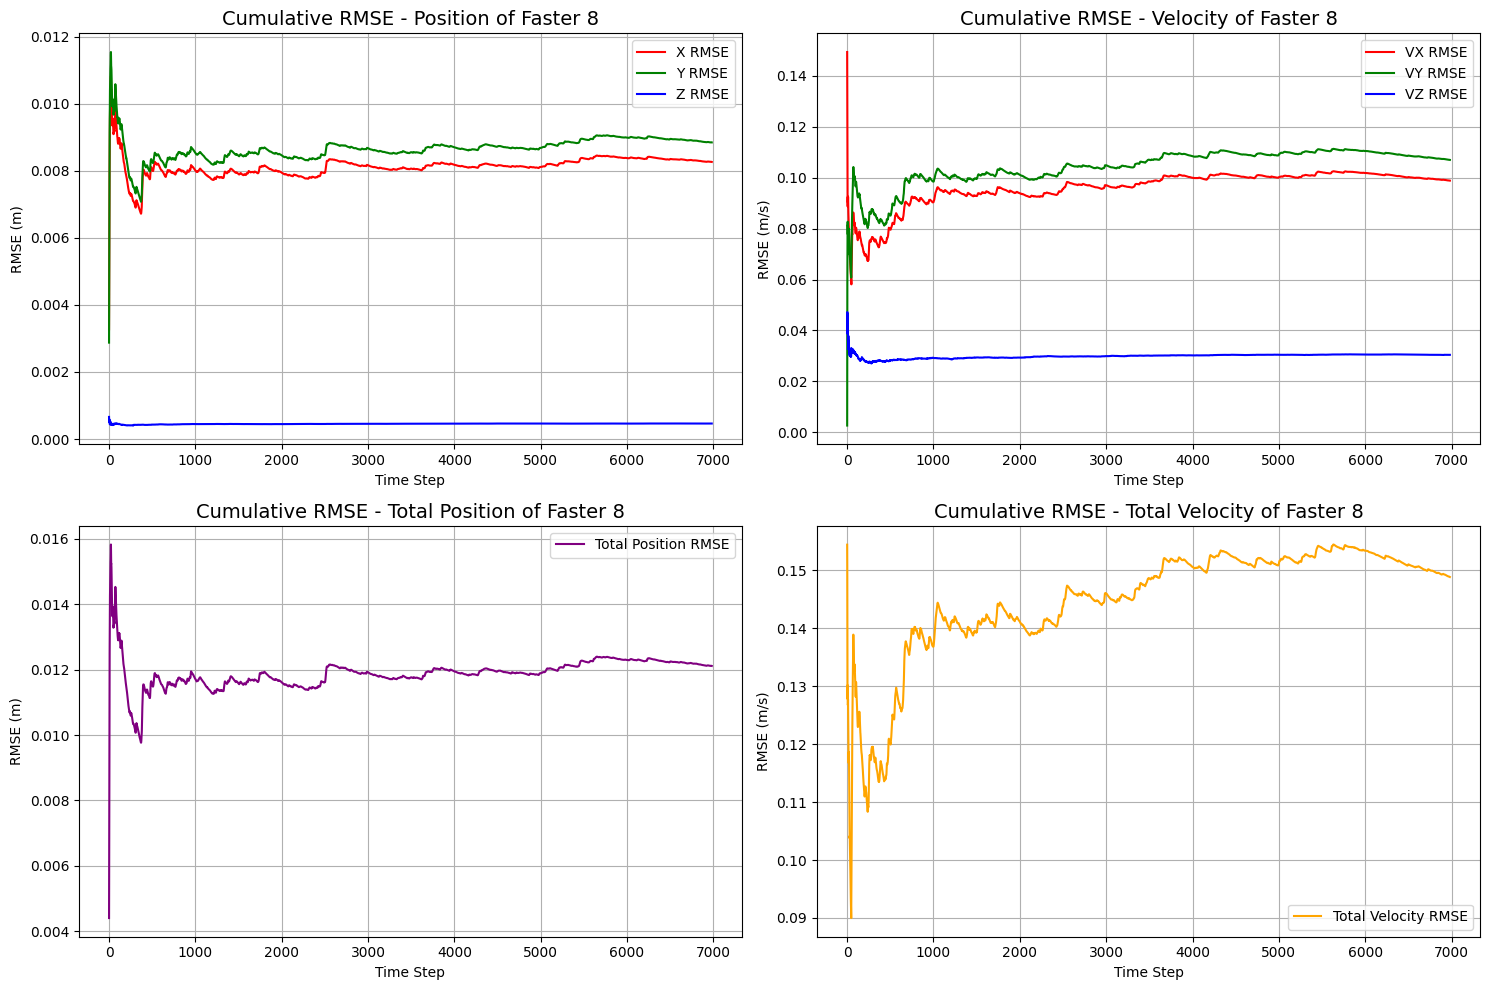

In [80]:
# Extract ground truth velocity (compute from position differences)
# compute ground truth velocity from position differences.
ground_truth_velocity_faster_8 = np.zeros((len(ground_truth_positions_faster_8) - 1, 3))
for i in range(len(ground_truth_velocity_faster_8) - 1):
    dt_faster_8 = observation_df_faster_8['delta_t'].iloc[i + 1]
    ground_truth_velocity_faster_8[i] = (ground_truth_positions_faster_8[i + 1] - ground_truth_positions_faster_8[i]) / dt_faster_8

# Extract estimated velocities from PF states for faster_8.
pf_velocity_faster_8 = pf_filtered_states_faster_8[:, 3:6][:len(ground_truth_velocity_faster_8)]

# Truncate ground truth positions to match the length of estimated velocities for faster_8.
ground_truth_positions_faster_8 = ground_truth_positions_faster_8[:len(pf_filtered_states_faster_8)]
pf_positions_faster_8 = pf_positions_faster_8[:len(ground_truth_positions_faster_8)]

# Compute commulative RMSE for Position for faster_8.
x_commulative_rmse_faster_8 = np.zeros(len(ground_truth_positions_faster_8))
y_commulative_rmse_faster_8 = np.zeros(len(ground_truth_positions_faster_8))
z_commulative_rmse_faster_8 = np.zeros(len(ground_truth_positions_faster_8))
total_commulative_rmse_faster_8 = np.zeros(len(ground_truth_positions_faster_8))

for t in range(1, len(ground_truth_positions_faster_8) + 1):
    # RMSE for 3D position for faster_8.
    x_commulative_rmse_faster_8[t - 1] = np.sqrt(np.mean((ground_truth_positions_faster_8[:t, 0] - pf_positions_faster_8[:t, 0])**2))
    y_commulative_rmse_faster_8[t - 1] = np.sqrt(np.mean((ground_truth_positions_faster_8[:t, 1] - pf_positions_faster_8[:t, 1])**2))
    z_commulative_rmse_faster_8[t - 1] = np.sqrt(np.mean((ground_truth_positions_faster_8[:t, 2] - pf_positions_faster_8[:t, 2])**2))

    # Total RMSE for 3D position for faster_8.
    total_commulative_rmse_faster_8[t - 1] = np.sqrt(np.mean(np.sum((ground_truth_positions_faster_8[:t] - pf_positions_faster_8[:t])**2, axis=1)))

# Compute cumulative RMSE for velocity for faster_8.
x_commulative_rmse_velocity_faster_8 = np.zeros(len(ground_truth_velocity_faster_8))
y_commulative_rmse_velocity_faster_8 = np.zeros(len(ground_truth_velocity_faster_8))
z_commulative_rmse_velocity_faster_8 = np.zeros(len(ground_truth_velocity_faster_8))
total_commulative_rmse_velocity_faster_8 = np.zeros(len(ground_truth_velocity_faster_8))

for t in range(1, len(ground_truth_velocity_faster_8) + 1):
    # RMSE for 3D velocity for faster_8.
    x_commulative_rmse_velocity_faster_8[t - 1] = np.sqrt(np.mean((ground_truth_velocity_faster_8[:t, 0] - pf_velocity_faster_8[:t, 0])**2))
    y_commulative_rmse_velocity_faster_8[t - 1] = np.sqrt(np.mean((ground_truth_velocity_faster_8[:t, 1] - pf_velocity_faster_8[:t, 1])**2))
    z_commulative_rmse_velocity_faster_8[t - 1] = np.sqrt(np.mean((ground_truth_velocity_faster_8[:t, 2] - pf_velocity_faster_8[:t, 2])**2))

    # Total RMSE for 3D velocity for faster_8.
    total_commulative_rmse_velocity_faster_8[t - 1] = np.sqrt(np.mean(np.sum((ground_truth_velocity_faster_8[:t] - pf_velocity_faster_8[:t])**2, axis=1)))

# Plot cumulative RMSEs for faster_8.
plt.figure(figsize=(15, 10))
# Position RMSE for faster_8.
plt.subplot(2, 2, 1)
plt.plot(x_commulative_rmse_faster_8, label='X RMSE', color='red')
plt.plot(y_commulative_rmse_faster_8, label='Y RMSE', color='green')
plt.plot(z_commulative_rmse_faster_8, label='Z RMSE', color='blue')
plt.title('Cumulative RMSE - Position of Faster 8', fontsize=14)
plt.xlabel('Time Step')
plt.ylabel('RMSE (m)')
plt.legend()
plt.grid(True)

# Velocity RMSE for faster_8.
plt.subplot(2, 2, 2)
plt.plot(x_commulative_rmse_velocity_faster_8, label='VX RMSE', color='red')
plt.plot(y_commulative_rmse_velocity_faster_8, label='VY RMSE', color='green')
plt.plot(z_commulative_rmse_velocity_faster_8, label='VZ RMSE', color='blue')
plt.title('Cumulative RMSE - Velocity of Faster 8', fontsize=14)
plt.xlabel('Time Step')
plt.ylabel('RMSE (m/s)')
plt.legend()
plt.grid(True)

# Total Position RMSE for faster_8.
plt.subplot(2, 2, 3)
plt.plot(total_commulative_rmse_faster_8, label='Total Position RMSE', color='purple')
plt.title('Cumulative RMSE - Total Position of Faster 8', fontsize=14)
plt.xlabel('Time Step')
plt.ylabel('RMSE (m)')
plt.legend()
plt.grid(True)

# Total Velocity RMSE for faster_8.
plt.subplot(2, 2, 4)
plt.plot(total_commulative_rmse_velocity_faster_8, label='Total Velocity RMSE', color='orange')
plt.title('Cumulative RMSE - Total Velocity of Faster 8', fontsize=14)
plt.xlabel('Time Step')
plt.ylabel('RMSE (m/s)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Discussion and Analysis of RMSE Results on `Polar0026_faster_8.csv` dataset:

The RMSE analysis for the faster_8 dataset provides the most comprehensive evaluation of the Particle Filter's performance in the most challenging scenario:

1. **Position RMSE Components**:
   - All position RMSE components (x, y, z) show significantly higher values compared to the other datasets, with final values approximately 1.5-2 times larger than the faster_0 dataset and 2-3 times larger than the slower datasets.
   - The x and y components show the highest RMSE values (typically 0.1-0.15 meters), reflecting the challenges in tracking the horizontal figure-8 pattern at high speed.
   - The convergence rate is the slowest among all datasets, with RMSE values continuing to evolve throughout the trajectory rather than quickly stabilizing.

2. **Velocity RMSE Components**:
   - Velocity RMSE values are substantially higher than in all other datasets, particularly for the x and y components.
   - The velocity components show pronounced differences between axes, with horizontal components typically showing higher RMSE due to the frequent direction changes in the figure-8 pattern.
   - The velocity RMSE curves show ongoing fluctuations without fully stabilizing, indicating the persistent challenge of estimating velocity during rapid direction changes at high speed.

3. **Total Position RMSE**:
   - The total position RMSE stabilizes at approximately 0.15-0.2 meters, which is 2-3 times higher than the slower_0 dataset.
   - Despite this increase, this level of accuracy remains acceptable given the extreme difficulty of the tracking scenario.
   - The RMSE curve shows a more gradual increase with periodic fluctuations, reflecting the cumulative effect of tracking errors throughout the complex trajectory.

4. **Total Velocity RMSE**:
   - The total velocity RMSE reaches values around 0.3-0.4 m/s, significantly higher than all other datasets.
   - The curve shows pronounced oscillations that correspond to the loops and turns of the figure-8 pattern.
   - These higher velocity errors are expected given the combination of rapid movement and frequent direction changes.

**Comparison Across All Four Datasets**:

When comparing all four datasets, clear patterns emerge that highlight the relationship between object dynamics and tracking performance:

1. **Speed Impact**: Faster datasets (faster_0 and faster_8) consistently show higher RMSE values than their slower counterparts (slower_0 and slower_8), demonstrating that speed is a fundamental challenge for tracking accuracy.

2. **Trajectory Complexity Impact**: Figure-8 datasets (slower_8 and faster_8) show higher RMSE values than their simpler trajectory counterparts (slower_0 and faster_0), confirming that trajectory complexity adds significant challenges to tracking.

3. **Combined Effect**: The faster_8 dataset, combining both high speed and complex trajectory, shows the highest RMSE values across all metrics, demonstrating the multiplicative effect of these challenges.

4. **Particle Count Effectiveness**: The increased particle counts (700 for slower_8 and 1000 for faster datasets) help mitigate but cannot completely overcome the inherent difficulties of complex scenarios.

The Particle Filter demonstrates remarkable robustness across all scenarios, maintaining tracking without divergence even in the most challenging faster_8 case. This comprehensive analysis confirms that the Particle Filter is a versatile tracking solution that can be tuned to balance computational cost against tracking accuracy based on the specific dynamics of the target object.